# **1. data_engineering**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
import re

In [2]:
#%run data_cleaning_ICC.ipynb

# load the cleaned up data ready for feature engineering.
icc_clean= pd.read_csv("icc_analysis/cleaned_icc_data.csv")


In [3]:

# Prepare DataFrame
icc_features = pd.DataFrame()
icc_features['ID'] = icc_clean['RESPNR']

In [4]:
# General utility function for mapping medicines
def map_medicine(row, medicine_mapping):
    """ Map medicine codes to category values. """
    return medicine_mapping.get(row['MEDICINE'], None)

# Medicine Mapping
medicine_mapping = {180: 1, 290: 1, 202: 2}

# Map Medicine
icc_features['Medicine'] = icc_clean.apply(map_medicine, axis=1, medicine_mapping=medicine_mapping)


## **Age at diagnosis and at inclusion**

In [5]:
def calculate_age_at_diagnosis(diagnosis_date, birth_year):
    """ Calculate age at diagnosis. """
    diagnosis_date = pd.to_datetime(diagnosis_date)
    return diagnosis_date.year - birth_year if pd.notnull(diagnosis_date) and pd.notnull(birth_year) else np.nan

def calculate_age_at_inclusion(inclusion_date, birth_year):
    """ Calculate age at inclusion. """
    inclusion_date = pd.to_datetime(inclusion_date)
    return inclusion_date.year - birth_year if pd.notnull(inclusion_date) and pd.notnull(birth_year) else np.nan

def categorize_age(age_series, bins, labels):
    """ Categorize individuals into age groups. """
    return pd.cut(age_series, bins=bins, labels=labels, right=False)

# Age Calculation
icc_features['AgeDiagnosis'] = icc_clean.apply(lambda row: calculate_age_at_diagnosis(row['D_DATE'], row['BIRTHYEAR']), axis=1)
icc_features['AgeInclusion'] = icc_clean.apply(lambda row: calculate_age_at_inclusion(row['W1_PLANVISDAT'], row['BIRTHYEAR']), axis=1)

# Age Group Categorization
# categorise in age ranges: <16 (1), 16-24 (2), 25-60 (3), >60 (4)
bins = [0, 16, 24, 60, np.inf]
labels = [1, 2, 3, 4]

icc_features['AgeDiagnosisGroup'] = categorize_age(icc_features['AgeDiagnosis'], bins,labels)
icc_features['AgeInclusionGroup'] = categorize_age(icc_features['AgeInclusion'], bins, labels)

## **Disease duration**

In [6]:
# disease duration from diagnosis til inclusion. In years.
# diagnosis: D_DATE
# inclusion: W1_PLANVISDAT

def calculate_duration(start_date, end_date):
    """ Calculate disease duration in years. """
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    return end_date.year - start_date.year if pd.notnull(start_date) and pd.notnull(end_date) else np.nan

# Duration Calculation
icc_features['Duration'] = icc_clean.apply(lambda row: calculate_duration(row['D_DATE'], row['W1_PLANVISDAT']), axis=1)

# Duration Group Categorization: categorise in ranges: <2 (1), 2-5 (2), >5 (3)
duration_bins = [0, 2, 5, np.inf]
duration_labels = [1, 2, 3]
icc_features['DurationGroup'] = categorize_age(icc_features['Duration'], duration_bins, duration_labels)


## **BMI**

In [7]:
# BMI (length and weigth): <18.5, 18.5-24.9, 25.0-29.9, >30.0
# calculate using: W1_HEIGHT, W1_WEIGHT

def calculate_bmi(height, weight):
    """ Calculate BMI from height and weight. """
    return weight / ((height / 100) ** 2)
    
def categorize_bmi(bmi_series, bins, labels):
    """ Categorize BMI into predefined groups. """
    return pd.cut(bmi_series, bins=bins, labels=labels, right=False)

# BMI Calculation and Categorization: <18.5 (1), 18.5-24.9 (2), 25.0-29.9 (3), >30.0 (4)

icc_features['BMI'] = icc_clean.apply(lambda row: calculate_bmi(row['W1_HEIGHT'], row['W1_WEIGHT']), axis=1)
bmi_bins = [0, 18.5, 24.9, 29.9, np.inf]
bmi_labels = [1, 2, 3, 4]
icc_features['BMIGroup'] = categorize_bmi(icc_features['BMI'], bmi_bins, bmi_labels)


## **Smoking, Gender, Disease Location, and Behavior**

In [8]:
# at diagnosis: D_MON_LOC_CD
# at inclusion: W1_MON_LOC_CD_INC
# ileum (1) = 1, 4; colon (2) = 2, 6; both (3) = 3, 5

def map_location(row, col, location_mapping):
    """ Map disease location codes to categories. """
    return location_mapping.get(row[col], None)

# Location Mapping
location_mapping = {1: 1, 4: 1, 2: 2, 6: 2, 3: 3, 5: 3}

# Smoking, Gender, Disease Location, and Behavior
icc_features['Smoking'] = icc_clean['W1_SMOK']# at inclusion W1_SMOK 1: never, 2: past, 3: current
icc_features['Gender'] = icc_clean['SEX']#  1 = male, 2 = female
icc_features['LocationDiagnosis'] = icc_clean.apply(map_location, axis=1, col='D_MON_LOC_CD', location_mapping=location_mapping)
icc_features['LocationInclusion'] = icc_clean.apply(map_location, axis=1, col='W1_MON_LOC_CD_INC', location_mapping=location_mapping)

# at diagnosis: D_MON_BEH_CD
# at inclusion: W1_MON_BEH_CD_INC
# inflammatory (1) = 1; stricturing (2) = 2; penetrating (3) = 3
icc_features['BehaviorDiagnosis'] = icc_clean['D_MON_BEH_CD']
icc_features['BehaviorInclusion'] = icc_clean['W1_MON_BEH_CD_INC']

## **Calpro**

In [9]:
# icc_clean W1_LAB_CAL
icc_features['Calpro'] = icc_clean['W1_LAB_CAL']

# Calpro Group Categorization
calpro_bins = [0, 100, 250, np.inf]
calpro_labels = [1, 2, 3]
icc_features['CalproGroup'] = pd.cut(icc_features['Calpro'], bins=calpro_bins, labels=calpro_labels, right=False)
icc_features.loc[icc_features['Calpro'].isnull(), 'CalproGroup'] = np.nan

## **CRP**

In [10]:
# --> W1_LAB_CRP
icc_features['CRP'] = icc_clean['W1_LAB_CRP']

# CRP Group Categorization: CRP: <10 (1), >10 (2)
crp_bins = [0, 10, np.inf]
crp_labels = [1, 2]
icc_features['CRPGroup'] = pd.cut(icc_features['CRP'], bins=crp_bins, labels=crp_labels, right=False)
icc_features.loc[icc_features['CRP'].isnull(), 'CRPGroup'] = np.nan

## **Thrombocytes**

In [11]:
# icc_clean W1_LAB_TB

icc_features['Thrombocytes'] = icc_clean['W1_LAB_TB']

# Thrombocytes Group Categorization
thrombocytes_bins = [0, 130, 350, np.inf]
thrombocytes_labels = [1, 2, 3]
icc_features['ThrombocytesGroup'] = pd.cut(icc_features['Thrombocytes'], bins=thrombocytes_bins, labels=thrombocytes_labels, right=False)
icc_features.loc[icc_features['Thrombocytes'].isnull(), 'ThrombocytesGroup'] = np.nan

## **Apendectomy**

In [12]:
# apendectomy in the medical history of patient: no (0), yes (1)
# --> MH_AP_UC

icc_features['Apendectomy'] = icc_clean['MH_AP_UC']

## **Medical history**

In [13]:
# medical history: cancer yes (1), cancer no (0)
# --> Ever cancer: CM_C_CRC, CM_C_L, CM_C_BR, CM_C_NHL, CM_C_NMSC, CM_C_MSC, CM_C_P, CM_C_CX, CM_C_O

conditions = [
    icc_clean[['CM_C_CRC', 'CM_C_L', 'CM_C_BR', 'CM_C_NHL', 'CM_C_NMSC', 'CM_C_MSC', 'CM_C_P', 'CM_C_CX', 'CM_C_O']].eq(1).any(axis=1),
    icc_clean[['CM_C_CRC', 'CM_C_L', 'CM_C_BR', 'CM_C_NHL', 'CM_C_NMSC', 'CM_C_MSC', 'CM_C_P', 'CM_C_CX', 'CM_C_O']].isnull().all(axis=1)
]
choices = [1, np.nan]
icc_features['CancerEver'] = np.select(conditions, choices, default=0)


## **Prior surgery**

In [14]:
import numpy as np

# Combine the surgery columns into a single column indicating any surgery (1) or no surgery (0)
surgery_columns = ['MH_CD_PREV_SUR', 'MH_CD_PERIAN_SUR', 'W1_CO_CD_SUR', 'W1_CO_CD_PERIANSUR']

# Condition 1: If any of the surgery columns is marked as 'yes' (1), prior surgery is present.
prior_surgery_any = icc_clean[surgery_columns].eq(1).any(axis=1)

# Condition 2: If 'MH_CD_PREV_SUR' is 2, meaning previous surgery on colon, assign prior surgery.
prior_surgery_colon = icc_clean['MH_CD_PREV_SUR'].eq(2)

# Condition 3: If 'MH_CD_PREV_SUR' is 3, meaning previous surgery on both colon and small intestine.
prior_surgery_colon_intestine = icc_clean['MH_CD_PREV_SUR'].eq(3)

# Condition 4: If all surgery-related columns are NaN, meaning no surgery info, handle as missing.
no_surgery_info = icc_clean[surgery_columns].isna().all(axis=1)

# Combine all conditions
conditions = [
    prior_surgery_any,                  # Any surgery
    prior_surgery_colon,                 # Surgery on colon
    prior_surgery_colon_intestine,       # Surgery on colon and intestine
    no_surgery_info                      # No surgery info
]

# Define corresponding choices for each condition
choices = [1, 1, 1, np.nan]  # Assign 1 if any surgery is present, else NaN for missing data

# Use np.select to apply conditions and set the 'PriorSurgery' column
icc_features['PriorSurgery'] = np.select(conditions, choices, default=0)

# Check the result to verify
icc_features['PriorSurgery'].value_counts()


PriorSurgery
1.0    335
0.0    228
Name: count, dtype: int64

## **Extraintestinal manifestations (EIM)**

In [15]:
# EIM: W1_HB_JOINT (arthralgia), W1_HB_ARTHRITIS (arthritis), W1_HB_EYE (uveitis), W1_HBI_MOUTH (aphthous stomatitis),
# W1_HB_EN (erytheam nodosum), W1_HB_PG (pyoderma gangrenosum), W1_HB_ANALFIS (anal fissure), 
# W1_HB_PERIANFIS (perianal new fistula), W1_HB_PERIANAB (perianal abcess), W1_FISTEL_Y_N (fistel), 
# W1_PERIAN_DRAIN (drainage perianal fistula)

# 1. None
# 2. rheumatic W1_HB_JOINT, W1_HB_ARTHRITIS
# 3. skin W1_HB_EN, W1_HB_PG, W1_HBI_MOUTH, W1_HB_ANALFIS, W1_HB_PERIANFIS, W1_HB_PERIANAB, W1_FISTEL_Y_N, W1_PERIAN_DRAIN
# 4. other W1_HB_EYE

# maybe make different variables... EIMRheu, EIMSkin, EIMOther

In [16]:
# Create reusable function for conditions
def create_eim_condition(columns, value=1):
    """Return condition for checking if any of the specified columns equals the given value."""
    return icc_clean[columns].eq(value).any(axis=1)

# Create reusable function for null checks
def create_null_condition(columns):
    """Return condition to check if all values in the specified columns are null."""
    return icc_clean[columns].isnull().all(axis=1)

# Binary. Whether any EIM present 1 or not 0, , 'W1_HB_ARTHRITIS' is null
eim_columns =['W1_HB_JOINT', 'W1_HB_EYE', 'W1_HBI_MOUTH', 'W1_HB_EN', 'W1_HB_PG', 'W1_HB_ANALFIS', 
               'W1_HB_PERIANFIS', 'W1_HB_PERIANAB', 'W1_FISTEL_Y_N', 'W1_PERIAN_DRAIN']
eim_columns1 = ['W1_PERIAN_DRAIN']
icc_features['EIM'] = np.select(
    [create_eim_condition(eim_columns, 1),
     create_eim_condition(eim_columns1, 1), 
     create_null_condition(eim_columns)],
    [1,1, np.nan],
    default=0
)


# Conditions for Rheumatic EIM (joint or arthritis)
rheumatic_columns = ['W1_HB_JOINT']#, 'W1_HB_ARTHRITIS']
icc_features['EIMRhe'] = np.select(
    [create_eim_condition(rheumatic_columns, 1), create_null_condition(rheumatic_columns)],
    [1, np.nan],
    default=0
)

# Conditions for Skin EIM (mouth, EN, PG, anal fissure, perianal issues, fistula, drainage)
skin_columns = ['W1_HBI_MOUTH', 'W1_HB_EN', 'W1_HB_PG', 'W1_HB_ANALFIS', 
                'W1_HB_PERIANFIS', 'W1_HB_PERIANAB', 'W1_FISTEL_Y_N',
                'W1_PERIAN_DRAIN']
icc_features['EIMSkin'] = np.select(
    [create_eim_condition(skin_columns, 1), create_null_condition(skin_columns)],
    [1, np.nan],
    default=0
)

# Conditions for Other EIM (eye - uveitis)
icc_features['EIMOther'] = np.select(
    [icc_clean['W1_HB_EYE'].eq(1), icc_clean['W1_HB_EYE'].isnull()],
    [1, np.nan],
    default=0
)

# Classify all EIMs into categories: 0 = none, 1 = rheumatic, 2 = skin, 3 = other, 4 = rhe + skin, 5 = rhe + other, 6 = skin + other, 7 = all
# EIM all in one. categories
# 0: none
# 1: rheumatic
# 2: skin
# 3: other
# 4: rhe + skin
# 5: rhe + other
# 6: skin + other
# 7: all
icc_features['EIMClassified'] = np.select(
    [
        (icc_features['EIMRhe'].eq(1) & icc_features['EIMSkin'].eq(0) & icc_features['EIMOther'].eq(0)),
        (icc_features['EIMRhe'].eq(0) & icc_features['EIMSkin'].eq(1) & icc_features['EIMOther'].eq(0)),
        (icc_features['EIMRhe'].eq(0) & icc_features['EIMSkin'].eq(0) & icc_features['EIMOther'].eq(1)),
        (icc_features['EIMRhe'].eq(1) & icc_features['EIMSkin'].eq(1) & icc_features['EIMOther'].eq(0)),
        (icc_features['EIMRhe'].eq(1) & icc_features['EIMSkin'].eq(0) & icc_features['EIMOther'].eq(1)),
        (icc_features['EIMRhe'].eq(0) & icc_features['EIMSkin'].eq(1) & icc_features['EIMOther'].eq(1)),
        (icc_features['EIMRhe'].eq(1) & icc_features['EIMSkin'].eq(1) & icc_features['EIMOther'].eq(1)),
        (icc_features['EIMRhe'].isnull() & icc_features['EIMSkin'].isnull() & icc_features['EIMOther'].isnull())
    ],
    [1, 2, 3, 4, 5, 6, 7, np.nan],
    default=0
)




## **Perianal disease**

In [17]:
# perianal disease yes 1, no 0
icc_features['PerianalDisease'] = icc_clean['D_MON_PERIAN_CD']

## **Charlson Comorbidity Index (CCI)**

In [18]:
# number of comorbidities
# --> columns indicating presence of a specific comorbidity
# --> CM_M_DM, CM_M_HCHOL, CM_IN_HIV, CM_IN_HV, CM_NEU_EP, CM_NEU_MIG, CM_NEU_PAR, CM_HEAR, CM_VIS, CM_CV_AH,
# --> CM_CV_CVA, CM_CV_HEARTC, CM_CV_HEARTD, CM_CV_HEARTR, CM_CV_HEARTV, CM_LUNG_ASTMA, CM_LUNG_COPD, CM_SKIN_PS, CM_SKIN_E, 
# --> CM_RI, CM_ALC_LIV, CM_ALC_O, CM_LM_RA, CM_LM_SPA, CM_LM_OP, CM_LM_PA, CM_LM_CB, CM_IM_C, CM_IM_O, CM_PSY_MR, CM_PSY_DEM,
# --> CM_PSY_DR, CM_PSY_ALC, CM_PSY_DEP, CM_PSY_A, CM_PSY_ASS, CM_PSY_ADHD, CM_PSY_B, CM_PSY_P, CM_PSY_BO
# weights calculated based on https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6684052/

# weights:
# Myocardial infarction: 1
# Congestive heart failure: 1
# - CVA 'CM_CV_CVA'
# - coronary heart disease 'CM_CV_HEARTC'
# - heart decompensation 'CM_CV_HEARTD'
# Peripheral vascular disease: 1
# Cerebrovascular disease: 1
# Dementia: 1
# - mental impairment 'CM_PSY_MR'
# - dementia 'CM_PSY_DEM'
# Chronic pulmonary disease: 1
# - asthma 'CM_LUNG_ASTMA'
# - COPD 'CM_LUNG_COPD'
# Rheumatic disease: 1
# - rheumathoid arthritis 'CM_LM_RA'
# Peptic ulcer disease: 1
# Mild liver disease: 1
# - Hepatitis B/C 'CM_IN_HV'
# - chronic alcoholic liver disease 'CM_ALC_LIV'
# - other alcohol realted disease 'CM_ALC_O'
# Diabetes without chronic complications: 1
# - diabetes mellitus 'CM_M_DM'
# Diabetes with chronic complications: 2
# Hemiplegia or paraplegia: 2
# Renal disease: 2
# Moderate or severe liver disease: 3
# - chronic kidney failure 'CM_RI'
# Metastatic solid tumor: 6
# AIDS/HIV: 6
# - HIV 'CM_IN_HIV'


# Define the weights for each comorbidity
weights = {
    'CM_M_DM': 1,
    'CM_IN_HIV': 6, 
    'CM_IN_HV': 1,
    'CM_CV_CVA': 1,
    'CM_CV_HEARTC': 1,
    'CM_CV_HEARTD': 1,
    'CM_CV_HEARTV': 1,
    'CM_LUNG_ASTMA': 1,
    'CM_LUNG_COPD': 1,
    'CM_RI': 3,
    'CM_ALC_LIV': 1,
    'CM_ALC_O': 1,
    'CM_LM_RA': 1,
    'CM_PSY_MR': 1,
    'CM_PSY_DEM': 1,
}

# List of columns indicating the presence of comorbidities
comorbidity_cols = [
    'CM_M_DM', 'CM_IN_HIV', 'CM_IN_HV', 'CM_CV_CVA', 'CM_CV_HEARTC', 'CM_CV_HEARTV', 
    'CM_LUNG_ASTMA', 'CM_LUNG_COPD', 'CM_RI', 'CM_ALC_LIV', 'CM_ALC_O', 'CM_LM_RA', 
    'CM_PSY_MR', 'CM_PSY_DEM'
]

# Function to compute CCI for a single row
def compute_cci(row, weights, comorbidity_cols):
    # Sum weights of comorbidities present (1 = presence of comorbidity)
    return sum(weights[disease] for disease in comorbidity_cols if row[disease] == 1)

# Apply CCI computation to each row in the dataset
icc_features['CCI'] = icc_clean[comorbidity_cols].apply(
    lambda row: compute_cci(row, weights, comorbidity_cols), axis=1
)

# Handle missing values - if any comorbidity column is missing, set CCI to NaN
icc_features['CCI'] = icc_features['CCI'].where(icc_clean[comorbidity_cols].notnull().all(axis=1), np.nan)


# if CCI was calculated the most accurately, any missing value in comorbidity would result in CCI = null.
# however, then all the CCI values are null. 
print(sum(icc_features['CCI'] ))

nan


In [19]:
# check null proportions. 14 values in total
cci_null = pd.DataFrame()
cci_null['ID'] = icc_clean['RESPNR']
cci_null['Null_Count'] = icc_clean[comorbidity_cols].isnull().sum(axis=1)

In [20]:
#for index, row in cci_null.iterrows():
    #if row['Null_Count'] == 0:
        #print(row['ID'], row['Null_Count'])
        
# none...

In [21]:
cci_id = []
for index, row in cci_null.iterrows():
    if row['Null_Count'] != 0 and row['Null_Count'] != 14:
        cci_id.append(row['ID'])
        #print(row['ID'], row['Null_Count'])

In [22]:
#print(cci_null.Null_Count.value_counts())

## **Previous medications**

In [23]:
# previous medication: prednison (corticosteroid), mesalazines (5-ASA), thiopurines, immunomodulators, 
# anti-TNF (infliximab, adalimumab, golimumab, certolizumab pegol), anti-leucine 12, anti-interkines, jak-inkibiteren
# --> MH_BUD, MH_CORT, MH_5_ASA, MH_THIO, MH_TGN, MH_MTX, MH_IFX, MH_ADA, MH_GOL, MH_CERT, MH_VEDO, MH_USTE, MH_TOFA, MH_O_BIO
# --> MH_O_BIO_BIN, MH_O_IMM_BIN, MH_O_IMM

# classes: prednison (1), mesalazines (2), thipurines (3), immunomodulators (4), anti-TNF (5), anti-IL-12 (6)
# anti-integrins (7), jak-inhibitors (8)

# mapping:
# 1: MH_BUD, MH_CORT
# 2: MH_5_ASA
# 3: MH_THIO, MH_TGN
# 4: MH_MTX
# 5: MH_IFX, MH_ADA, MH_GOL, MH_CERT
# 6: MH_USTE
# 7: MH_VEDO
# 8: MH_TOFA


# Medication mapping based on the classes
medication_classes = {
    'PrevMeds1': ['MH_BUD', 'MH_CORT'],  # Corticosteroids (Prednison)
    'PrevMeds2': ['MH_5_ASA'],  # Mesalazines (5-ASA)
    'PrevMeds3': ['MH_THIO', 'MH_TGN'],  # Thiopurines
    'PrevMeds4': ['MH_MTX'],  # Immunomodulators
    'PrevMeds5': ['MH_IFX', 'MH_ADA', 'MH_GOL', 'MH_CERT'],  # Anti-TNF
    'PrevMeds6': ['MH_USTE'],  # Anti-IL-12
    'PrevMeds7': ['MH_VEDO'],  # Anti-integrins
    'PrevMeds8': ['MH_TOFA']  # JAK inhibitors
}

# Function to categorize medication usage (1 for used, 0 for not used, NaN for missing)
def categorize_medication(row, meds_list):
    # Check for any medication in the list with a value of 1
    if any(row[med] == 1 for med in meds_list):
        return 1
    elif all(row[med] == 0 for med in meds_list):  # Check if all are 0
        return 0
    else:
        return np.nan  # Return NaN if there is any missing value

# Apply categorization for each medication class
for col, meds_list in medication_classes.items():
    icc_features[col] = icc_clean[meds_list].apply(lambda row: categorize_medication(row, meds_list), axis=1)

# Handling missing values in specific columns (record null values as 0 as per expert opinion)
icc_features['PrevMeds6'] = icc_features['PrevMeds6'].fillna(0)  # MH_USTE is treated as 0 if missing


In [24]:
# map these manually.....

#print(icc_clean.MH_O_BIO_BIN.value_counts())
#print(icc_clean.MH_O_IMM.value_counts())

## **Other Biological Medications**

In [25]:
# other biological: MH_O_BIO. If this is 1, then explanation is in MH_O_BIO_BIN

# Mapping for biological medications based on the explanation in MH_O_BIO_BIN
medication_keywords = {
    'PrevMeds4': ['il-6', 'mongersen', 'gsk1605786', 'etrolizumab', 'mitsubishi', 'azathioprine', 'ozanimod', 'tacro'],  # IL-6 inhibitors, Mongersen, etc.
    'PrevMeds5': ['etanercept', 'infliximab'],  # Anti-TNF (Etanercept, Infliximab)
    'PrevMeds6': ['ustekinumab', 'uniti', 'il-23'],  # Anti-IL-23 (Ustekinumab, Uniti)
    'PrevMeds7': ['madcam', 'amgen', 'etrolizumab', 'anti-integrin', 'opera'],  # Anti-integrins (Madcam, Amgen)
    'PrevMeds8': ['celest', 'filgotinib', 'upadacitinib']  # JAK inhibitors (Filgotinib, Upadacitinib)
}


# Function to categorize the medications based on the keywords in MH_O_BIO_BIN
def categorize_biological(row, medication_keywords):
    if row['MH_O_BIO'] == 1:
        results = {}
        for col, keywords in medication_keywords.items():
            # Check if any of the keywords are found in MH_O_BIO_BIN (case insensitive)
            if any(keyword in row['MH_O_BIO_BIN'].lower() for keyword in keywords):
                results[col] = 1
        return results
    return {}

# Apply the categorization for each row
for index, row in icc_clean.iterrows():
    medication_classes = categorize_biological(row, medication_keywords)
    for med_class in medication_classes:# If a match was found, set the corresponding medication column to 1
        icc_features.loc[index, med_class] = 1
    


##  **immunomodulator medications**

In [26]:
# immunomodulator: MH_O_IMM_BIN if t his is 1, then explanation is MH_O_IMM
# Mapping for immunomodulators based on the explanation in MH_O_IMM
immunomodulator_keywords = {
    'PrevMeds1': ['prednison'],  # Prednison (Corticosteroid)
    'PrevMeds4': ['tacrolimus', 'azathioprine', 'cyclosporine', 'mycofenolaatmofetil', 'tacrolimus, ciclosporine'],  # Immunosuppressants (Tacrolimus, Azathioprine, Cyclosporine)
    'PrevMeds7': ['anti-madcam in trial verband']  # Anti-Madcam in trial
}

# Function to categorize immunomodulators based on MH_O_IMM
def categorize_immunomodulator(row, immunomodulator_keywords):
    if row['MH_O_IMM_BIN'] == 1:
        results = {}
        for col, keywords in immunomodulator_keywords.items():
            # Use exact matching instead of partial matching
            if row['MH_O_IMM'] in keywords:
                results[col] = 1
        return results
    return {}

# Apply the categorization for each row
for index, row in icc_clean.iterrows():
    medication_matches = categorize_immunomodulator(row, immunomodulator_keywords)
    for med_class, value in medication_matches.items():
        icc_features.loc[index, med_class] = value


To create the `PrevMeds` variable with categories for monoclonal, non-monoclonal, both, or none, we can use a similar approach. We will map the medications into two categories based on their class: **monoclonal** and **non-monoclonal**, and apply conditions to create the `PrevMeds` variable.


### Explanation:

1. **Monoclonal Medications**: These include medications like anti-TNF, anti-IL-12, and anti-integrins.
   - `PrevMeds5`: Anti-TNF (e.g., Infliximab, Adalimumab, etc.)
   - `PrevMeds6`: Anti-IL-12 (e.g., Ustekinumab)
   - `PrevMeds7`: Anti-integrins (e.g., Vedolizumab)

2. **Non-Monoclonal Medications**: These include Corticosteroids (e.g., Prednison), Mesalazines (e.g., 5-ASA), Immunomodulators, etc.
   - `PrevMeds1`: Prednison (Corticosteroid)
   - `PrevMeds2`: Mesalazines (5-ASA)
   - `PrevMeds3`: Thiopurines
   - `PrevMeds4`: Immunomodulators
   - `PrevMeds8`: Jak-Inhibitors

3. **Categories**:
   - **0**: None (No medication used)
   - **1**: Monoclonal (Monoclonal medication is used, but no non-monoclonal)
   - **2**: Non-Monoclonal (Non-monoclonal medication is used, but no monoclonal)
   - **3**: Both (Both monoclonal and non-monoclonal medications are used)

In [27]:
# make one variable prevmeds. categories: monoclonal and non-monoclonal
# 0: none
# 1: monoclonal
# 2: non-monoclonal
# 3: both
# classes: prednison (1), mesalazines (2), thipurines (3), immunomodulators (4), anti-TNF (5), anti-IL-12 (6)
# anti-integrins (7), jak-inhibitors (8)

# Define the columns for monoclonal and non-monoclonal medications
med_cols = ['PrevMeds1', 'PrevMeds2', 'PrevMeds3', 'PrevMeds4', 'PrevMeds5', 'PrevMeds6', 'PrevMeds7', 'PrevMeds8']
monoc_cols = ['PrevMeds5', 'PrevMeds6', 'PrevMeds7']
nmonoc_cols = ['PrevMeds1', 'PrevMeds2', 'PrevMeds3', 'PrevMeds4', 'PrevMeds8']

# Define the conditions for categorizing 'PrevMeds'
conditions = [
    # Monoclonal used but no non-monoclonal
    (icc_features[monoc_cols].eq(1).any(axis=1) & icc_features[nmonoc_cols].eq(0).all(axis=1)),
    
    # Non-monoclonal used but no monoclonal
    (icc_features[monoc_cols].eq(0).all(axis=1) & icc_features[nmonoc_cols].eq(1).any(axis=1)),
    
    # Both monoclonal and non-monoclonal used
    (icc_features[monoc_cols].eq(1).any(axis=1) & icc_features[nmonoc_cols].eq(1).any(axis=1)),
    
    # Missing values in any of the medication columns
    icc_features[med_cols].isnull().any(axis=1)
]

# Define the choices for the corresponding categories
choices = [1, 2, 3, np.nan]  # 1: Monoclonal, 2: Non-Monoclonal, 3: Both, NaN: Missing

# Apply the conditions to create the 'PrevMeds' column
icc_features['PrevMeds'] = np.select(conditions, choices, default=0)

# Check the value counts of 'PrevMeds'
icc_features['PrevMeds'].value_counts()


PrevMeds
3.0    548
2.0     13
Name: count, dtype: int64

## **Corticosteroid-free clinical and biochemical remission at 52 weeks**

In [28]:
# outcome variable
# corticosteroid free clinical and biochemical remission at 52 weeks (W4)
# --> HBI < 5 calculate as per ECCO guidelines http://www.e-guide.ecco-ibd.eu/resources/calculator/harvey-bradshaw-index
# --> not on corticosteroid
# --> normal CRP and calprotein. !!!!!!!!!!!!!! high percentage missing values CRP 57% and calpro 71%....
# --> not possible to calculate biochemical remission

# HBI at 52w scoring

# general wellbeing 'W4_HB_SSCAI_WB': 0-4
# abdominal pain 'W4_HB_PAIN': 0-3
# number of stools 'W4_HB_STOOL' : 0-9
# abdominal mass 'W4_PHYS_ABDMASS': 0-3 MISSING!!! deleted in the beginning because all values NULL
# --> refer to literature as abdominal mass is often excluded in measurement PMID 23632348
# arthralgia 'W4_HB_JOINT': 0-3
# uveitis 'W4_HB_EYE': 0-1
# aphthous ulcers 'W4_HBI_MOUTH': 0-1
# erytheum nodosum 'W4_HB_EN': 0-1
# pyoderma gangrenosum 'W4_HB_PG': 0-1
# anal fissure 'W4_HB_ANALFIS': 0-1
# perianal new fistula 'W4_HB_PERIANFIS': 0-1
# perianal abcess 'W4_HB_PERIANAB': 0-1

In [29]:
# remap values in general wellbeing 'W4_HB_SSCAI_WB' as so
# 0: Very well – 7-10
# 1: Slightly below par – 6
# 2: Poor – 5 
# 3: Very poor – 4
# 4: Terrible – 0-3

# Step 1: Remap the general wellbeing values 
#----------------------------------------------------------
remap_dict = {
    11: 0,     10: 0,     9: 0,     8: 0,     7: 0,
    6: 1,
    5: 2,
    4: 3,
    3: 4,    2: 4,    1: 4,    0: 4
}

# Map the values of 'W4_HB_SSCAI_WB' to the new 'W4_HB_SSCAI_WB_remapped'
icc_clean['W4_HB_SSCAI_WB_remapped'] = icc_clean['W4_HB_SSCAI_WB'].map(remap_dict)

# Step 2: Calculate the HBI at 52 weeks (sum of relevant columns)
#----------------------------------------------------------
hbi_cols = ['W4_HB_SSCAI_WB_remapped', 'W4_HB_PAIN', 'W4_HB_STOOL', 'W4_HB_JOINT', 'W4_HB_EYE', 
            'W4_HBI_MOUTH', 'W4_HB_EN', 'W4_HB_PG', 'W4_HB_ANALFIS', 'W4_HB_PERIANFIS', 'W4_HB_PERIANAB']

# Calculate the HBI sum (NaN if all values are missing)
icc_features['HBI_52w'] = np.where(icc_clean[hbi_cols].isnull().all(axis=1),
                                   np.nan,
                                   icc_clean[hbi_cols].sum(axis=1, skipna=True))



/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


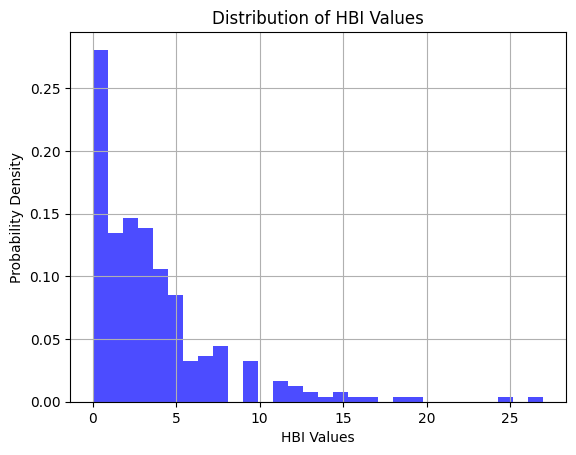

In [30]:
hbi_values = icc_features['HBI_52w']

plt.hist(hbi_values, bins=30, density=True, alpha=0.7, color='blue')
plt.title('Distribution of HBI Values')
plt.xlabel('HBI Values')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [31]:

# Step 3: Identify patients with missing values and count nulls for each patient in the HBI columns
#----------------------------------------------------------
hbi_null = pd.DataFrame()
hbi_null['ID'] = icc_clean['RESPNR']
hbi_null['Null_Count'] = icc_clean[hbi_cols].isnull().sum(axis=1)

# Step 4: if not whole row is not null or completely null.
#----------------------------------------------------------
null_patients = []
for index, row in hbi_null.iterrows():
    if row['Null_Count'] != 0 and row['Null_Count'] != 11:
        null_patients.append(row['ID'])
        #print(row['ID'], row['Null_Count'])




In [32]:
# Step 5: Manually identify patients with error margin more than 1 HBI unreliable and set HBI to NaN
#----------------------------------------------------------
# patients having 0-3 missing values in HBI
#for ID in null_patients:
    #print(ID)
    
# these patients manually analysed and the following information is missing and error margin in HBI calculation thereof:
# 4280: MOUTH; 1
# 4640: WB, PAIN, STOOL; 16
# 10580: WB; 4
# 13200: WB, STOOL; 13
# 1426: MOUTH; 1
# 17440: STOOL; 9
# 6440: PERIANFIS; 1
# 2241: MOUTH; 1
# 5840: MOUTH; 1
# 13860: STOOL; 9

# patients with error margin more than 1 HBI unreliable and thus changed to NULL: 4640 10580 13200 17440 13860
error_patients = [4640, 10580, 13200, 17440, 13860]
for ID in error_patients:
    icc_features.loc[icc_features['ID'] == ID, 'HBI_52w'] = np.nan

In [33]:
# Step 6: HBI categories
#----------------------------------------------------------
#print(icc_features.HBI_52w.value_counts())
# HBI categories:
# <5 Remission
# 5-7 Mild disease
# 8-16 Moderate disease
# >16 Severe disease

# hbi 52w groups
bins = [0, 5, 7, 16, np.inf]
labels = [1, 2, 3, 4]

icc_features['HBIGroup_52w'] = pd.cut(icc_features['HBI_52w'], bins=bins, labels=labels, right=False)
icc_features.loc[icc_features['HBI_52w'].isnull(), 'HBIGroup_52w'] = np.nan

In [34]:
# Step 7: Corticosteroid use at 52 weeks
#----------------------------------------------------------
icc_features['Steroid_52w'] = icc_clean['W4_CORT_BIN']

## **Outcome Variable: Remission**

In [35]:
# Step 8: Define remission based on HBI and corticosteroid use
#----------------------------------------------------------
# normal CRP (<10)
# W4_LAB_CRP
#icc_features['NormalCRP_52w'] = np.where(icc_clean['W4_LAB_CRP'].isnull(), np.nan, (icc_clean['W4_LAB_CRP'] < 100).astype(int))

# normal calpro (<100)
# W4_LAB_CAL
#icc_features['NormalCalpro_52w'] = np.where(icc_clean['W4_LAB_CAL'].isnull(), np.nan, (icc_clean['W4_LAB_CAL'] < 100).astype(int))

# combine HBI and cortocosteroid use to indicate whether patient is in remission or not
# cant use crp and calpro because too many missing values
conditions = (icc_features[['HBI_52w', 'Steroid_52w']].isnull()).any(axis=1)
icc_features['Remission_52w'] = np.where(conditions, np.nan, 
                                         ((icc_features['HBI_52w'] < 5) & (icc_features['Steroid_52w'] == 0))).astype(float)

# Step 9: Patients in remission while on corticosteroids
#----------------------------------------------------------
# also make column indicating the patients that use corticosteroid and are in remission
icc_features['Remission_steroid_52w'] = np.where(conditions, np.nan, 
                                         ((icc_features['HBI_52w'] < 5) & (icc_features['Steroid_52w'] == 1))).astype(float)



# Step 10: Update Remission_52w based on reasons for stopping treatment
#----------------------------------------------------------
# take WS_SREASON (reason why medication was stopped) for those patients who have HBI_52w = null. if the reason indicates,
# mark these patients as Remission_52w = 0 instead of null.

# WS_SREASON mappings
# 1: initiative patient themselves
# 2: no response
# 3: loss of response
# 4: side effects
# 5: unknown
# 6: pregnancy
# 7: stable remission
# 8: malignancy
# 9: other


# (WS_SREASON indicates why the treatment stopped)
for index, row in icc_clean.iterrows():
    if row['WS_SREASON'] == 2 or row['WS_SREASON'] == 3 or row['WS_SREASON'] == 4 or row['WS_SREASON'] == 8:
        icc_features.loc[index, 'Remission_52w'] = 0  # Not in remission due to failure
    if row['WS_SREASON'] == 7 and icc_features.loc[index, 'Steroid_52w'] == 0:
        icc_features.loc[index, 'Remission_52w'] = 1  # Stable remission, off steroids
    if row['WS_SREASON'] == 7 and icc_features.loc[index, 'Steroid_52w'] == 1:
        icc_features.loc[index, 'Remission_steroid_52w'] = 1  # Stable remission, on steroids

# Step 11: Remove rows with missing outcome values (Remission_52w)
#----------------------------------------------------------
icc_features = icc_features[icc_features.Remission_52w.notnull()]

# Step 12: Print the counts for the remission outcomes
#----------------------------------------------------------
print(icc_features.Remission_52w.value_counts())
print(icc_features.Remission_steroid_52w.value_counts())

# Additional: Display null counts for HBI and the number of error patients
#print(f"Patients with errors in HBI: {null_patients}")
print(f"Null value counts for HBI at 52 weeks: {icc_features['HBI_52w'].isnull().sum()}")



Remission_52w
0.0    283
1.0    164
Name: count, dtype: int64
Remission_steroid_52w
0.0    256
1.0     12
Name: count, dtype: int64
Null value counts for HBI at 52 weeks: 179


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


### **Process columns with high percentage missing values**

- Calculate the percentage of missing values per column and categorize columns based on these percentages.
- Visualize the distribution of missing values using a boxplot to identify columns with extreme missing data.
- Use quartiles to categorize columns and decide which ones should be dropped based on the amount of missing data.
- Remove columns that are unreliable due to excessive missing data or those that don’t contribute significantly to the analysis.

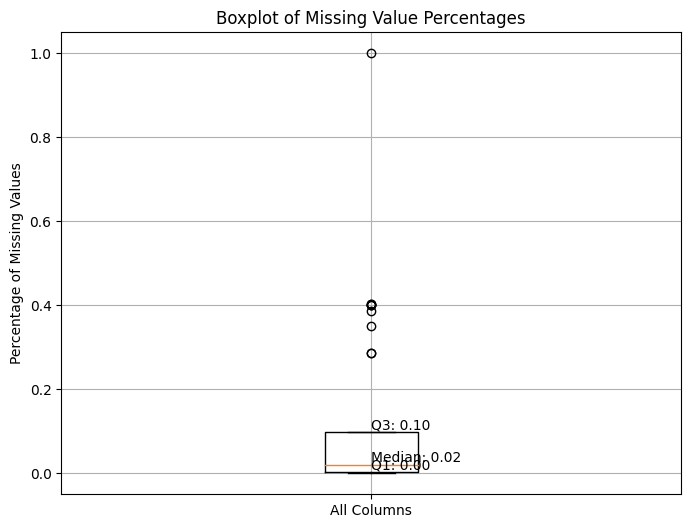

In [36]:
# Step 1: Calculate percentage of missing values per column
missing_values = icc_features.isnull().mean()  # Percentage of missing values
missing_values = missing_values.sort_values(ascending=False)

# Step 2: Visualize missing value percentages using a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(missing_values)
plt.title('Boxplot of Missing Value Percentages')
plt.ylabel('Percentage of Missing Values')
plt.xticks([1], ['All Columns'])
plt.grid(True)

# Calculate and annotate quartiles
quartiles = np.percentile(missing_values, [25, 50, 75])
plt.text(1, quartiles[0], f'Q1: {quartiles[0]:.2f}', ha='left', va='bottom')
plt.text(1, quartiles[1], f'Median: {quartiles[1]:.2f}', ha='left', va='bottom')
plt.text(1, quartiles[2], f'Q3: {quartiles[2]:.2f}', ha='left', va='bottom')

plt.show()

In [37]:
# Step 3: Create a DataFrame to analyze the missing values
missing_values_df = pd.DataFrame(missing_values).reset_index()
missing_values_df.columns = ['Column', 'MissingPercentage']


# Step 4: Calculate quartiles for categorizing columns
q1 = missing_values_df['MissingPercentage'].quantile(0.25)
q2 = missing_values_df['MissingPercentage'].quantile(0.50)
q3 = missing_values_df['MissingPercentage'].quantile(0.75)

# Step 5: Categorize columns based on quartiles of missing data
q1_columns = missing_values_df[missing_values_df['MissingPercentage'] <= q1]
q2_columns = missing_values_df[(missing_values_df['MissingPercentage'] > q1) & (missing_values_df['MissingPercentage'] <= q2)]
q3_columns = missing_values_df[(missing_values_df['MissingPercentage'] > q2) & (missing_values_df['MissingPercentage'] <= q3)]
q4_columns = missing_values_df[missing_values_df['MissingPercentage'] > q3]

# Step 6: Print the number of columns in each quartile and inspect them
print(f"Number of columns in Q1 (<= {q1} missing): {len(q1_columns)}")
print(f"Number of columns in Q2 ({q1} - {q2} missing): {len(q2_columns)}")
print(f"Number of columns in Q3 ({q2} - {q3} missing): {len(q3_columns)}")
print(f"Number of columns in Q4 (> {q3} missing): {len(q4_columns)}")


Number of columns in Q1 (<= 0.0022371364653243847 missing): 17
Number of columns in Q2 (0.0022371364653243847 - 0.020134228187919462 missing): 9
Number of columns in Q3 (0.020134228187919462 - 0.09787472035794184 missing): 8
Number of columns in Q4 (> 0.09787472035794184 missing): 12


In [38]:
# Step 7: Display columns with most missing values
print("Columns in Q4 (most missing values):")
print(q4_columns)

Columns in Q4 (most missing values):
                   Column  MissingPercentage
0                     CCI           1.000000
1             CalproGroup           0.402685
2                  Calpro           0.402685
3   Remission_steroid_52w           0.400447
4            HBIGroup_52w           0.400447
5                 HBI_52w           0.400447
6             Steroid_52w           0.387025
7                 Smoking           0.351230
8                     BMI           0.286353
9                BMIGroup           0.286353
10               CRPGroup           0.098434
11                    CRP           0.098434


In [39]:
# Step 8: Remove columns with too many missing values or irrelevant information
# These columns either have high missing data or aren't useful for analysis:
columns_to_drop = [
    'ID', 'CCI', 'EIMRhe', 'EIMSkin', 'EIMOther', 'EIMClassified', 'PrevMeds1', 'PrevMeds2',
    'PrevMeds3', 'PrevMeds4', 'PrevMeds5', 'PrevMeds6', 'PrevMeds7', 'PrevMeds8',
    'Steroid_52w', 'HBI_52w', 'HBIGroup_52w', 'Remission_steroid_52w'#, 
    # Add other columns with high missing values if needed:
   # 'BehaviorInclusion', 'Apendectomy', 'CRP', 'Thrombocytes', 'BMI', 'Smoking', 'Calpro'
]

# Remove the identified columns from the dataframe
icc_features = icc_features.drop(columns=columns_to_drop)

# Optional: Display remaining columns and their missing values
missing_values_after_drop = icc_features.isnull().mean()
missing_values_after_drop = missing_values_after_drop.sort_values(ascending=False)

print("Remaining columns with missing values:")
print(missing_values_after_drop)

Remaining columns with missing values:
CalproGroup          0.402685
Calpro               0.402685
Smoking              0.351230
BMI                  0.286353
BMIGroup             0.286353
CRPGroup             0.098434
CRP                  0.098434
ThrombocytesGroup    0.096197
Thrombocytes         0.096197
Apendectomy          0.085011
BehaviorDiagnosis    0.031320
BehaviorInclusion    0.026846
EIM                  0.020134
PerianalDisease      0.020134
LocationInclusion    0.013423
LocationDiagnosis    0.004474
DurationGroup        0.002237
Duration             0.002237
AgeInclusionGroup    0.002237
AgeInclusion         0.002237
PriorSurgery         0.000000
PrevMeds             0.000000
Medicine             0.000000
CancerEver           0.000000
AgeDiagnosis         0.000000
Gender               0.000000
AgeDiagnosisGroup    0.000000
Remission_52w        0.000000
dtype: float64


### **Drop all numerical values that have been categorized**

In [40]:
# drop columns that are not needed in structure learning for example continuous variables that have group variable
# using HBIGroup as outcome for now
icc_complete = icc_features.drop(columns=['AgeDiagnosis', 'AgeInclusion', 'Duration', 'BMI', 'CRP', 'Calpro', 'Thrombocytes'])

In [41]:
icc_complete.columns

Index(['Medicine', 'AgeDiagnosisGroup', 'AgeInclusionGroup', 'DurationGroup',
       'BMIGroup', 'Smoking', 'Gender', 'LocationDiagnosis',
       'LocationInclusion', 'BehaviorDiagnosis', 'BehaviorInclusion',
       'CalproGroup', 'CRPGroup', 'ThrombocytesGroup', 'Apendectomy',
       'CancerEver', 'PriorSurgery', 'EIM', 'PerianalDisease', 'PrevMeds',
       'Remission_52w'],
      dtype='object')

### **Replace NULL with 999** 

In [42]:
# Step 1: Identify categorical columns 
category_cols = [col for col in icc_features.columns if icc_features[col].dtype.name == 'category']
# Step 2: Replace NULL with 999 in categorical columns
for col in category_cols:
    # Check if 999 is already in the categories, and add it if not
    if 999 not in icc_features[col].cat.categories:
        icc_features[col] = icc_features[col].cat.add_categories([999])
    
    # Fill missing values with 999 in categorical columns
    icc_features[col].fillna(999, inplace=True)

# Step 3: Replace NULL with 999 for all other columns (if any)
icc_999 = icc_features.fillna(999)

# Optional: Verify changes for categorical columns
for col in category_cols:
    print(f"Column '{col}' after replacing NULL with 999:")
    print(icc_features[col].value_counts())

# Optional: Verify if any NULL values remain in the entire dataset after the fill operation
missing_after_fill = icc_999.isnull().sum().sum()
print(f"Remaining missing values in the dataset after replacement: {missing_after_fill}")


Column 'AgeDiagnosisGroup' after replacing NULL with 999:
AgeDiagnosisGroup
3      206
2      173
1       63
4        5
999      0
Name: count, dtype: int64
Column 'AgeInclusionGroup' after replacing NULL with 999:
AgeInclusionGroup
3      343
2       54
4       49
999      1
1        0
Name: count, dtype: int64
Column 'DurationGroup' after replacing NULL with 999:
DurationGroup
3      373
2       53
1       20
999      1
Name: count, dtype: int64
Column 'BMIGroup' after replacing NULL with 999:
BMIGroup
2      176
999    128
3       79
4       38
1       26
Name: count, dtype: int64
Column 'CalproGroup' after replacing NULL with 999:
CalproGroup
3      203
999    180
1       34
2       30
Name: count, dtype: int64
Column 'CRPGroup' after replacing NULL with 999:
CRPGroup
1      228
2      175
999     44
Name: count, dtype: int64
Column 'ThrombocytesGroup' after replacing NULL with 999:
ThrombocytesGroup
2      218
3      185
999     43
1        1
Name: count, dtype: int64
Remaining mi

<ipython-input-42-44a2a95c3d4f>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  icc_features[col].fillna(999, inplace=True)


## **Train and test data**


In [43]:
# datasets:
# icc_features: contains all the numerical and categorical features
# icc_complete: only categorical
# icc_999: icc_features but NULL values replaced by 999

# stratified by target variable. to keep the same target incidence in both data

# icc_features
icc_f_train, icc_f_test = train_test_split(icc_features, test_size=0.3, random_state=42, stratify=icc_complete.Remission_52w)

# icc_complete
icc_c_train, icc_c_test = train_test_split(icc_complete, test_size=0.3, random_state=42, stratify=icc_complete.Remission_52w)

# icc_999
icc_999_train, icc_999_test = train_test_split(icc_999, test_size=0.3, random_state=42, stratify=icc_complete.Remission_52w)

## **Statistics of the data**

In [44]:
from scipy.stats import ttest_ind

In [45]:
def basic_statistics(col):
    print(f"\n{'='*20} Statistics for {col} {'='*20}\n")
    
    # Create DataFrames for train and test statistics
    def get_statistics(data, name):
        value_counts = data[col].value_counts()
        percentages = (value_counts / len(data)) * 100
        
        # Create DataFrame with counts and percentages
        stats_df = pd.DataFrame({
            'Count': value_counts,
            'Percentage (%)': percentages.round(2)
        })
        
        # Add null values
        null_count = data[col].isnull().sum()
        null_percentage = (null_count / len(data)) * 100
        
        if null_count > 0:
            stats_df.loc['Null'] = [null_count, null_percentage.round(2)]
            
        stats_df.index.name = 'Value'
        stats_df['Dataset'] = name
        
        return stats_df
    
    # Get statistics for train and test
    train_stats = get_statistics(icc_c_train, 'Train')
    test_stats = get_statistics(icc_c_test, 'Test')
    
    # Combine train and test statistics
    combined_stats = pd.concat([train_stats, test_stats])
    combined_stats = combined_stats.reset_index()
    
    # Create a pivot table for side-by-side comparison
    pivot_stats = combined_stats.pivot(index='Value', 
                                     columns='Dataset', 
                                     values=['Count', 'Percentage (%)'])
    
    # Format the pivot table
    print("Distribution Statistics:")
    print(pivot_stats.round(2))
    
    # Perform t-test
    t_statistic, p_value = ttest_ind(icc_c_train[col], 
                                    icc_c_test[col], 
                                    nan_policy='omit')
    
    print(f"\nT-test Results:")
    t_test_df = pd.DataFrame({
        'Metric': ['T-statistic', 'P-value'],
        'Value': [t_statistic, p_value]
    }).set_index('Metric')
    
    print(t_test_df.round(4))

In [46]:
for col in icc_c_train.columns:
    basic_statistics(col)


==================== Statistics for Medicine ====================

Distribution Statistics:
        Count        Percentage (%)       
Dataset  Test  Train           Test  Train
Value                                     
1        59.0  123.0           43.7  39.42
2        76.0  189.0           56.3  60.58

T-test Results:
              Value
Metric             
T-statistic  0.8445
P-value      0.3988

==================== Statistics for AgeDiagnosisGroup ====================

Distribution Statistics:
        Count        Percentage (%)       
Dataset  Test  Train           Test  Train
Value                                     
1        19.0   44.0          14.07  14.10
2        50.0  123.0          37.04  39.42
3        64.0  142.0          47.41  45.51
4         2.0    3.0           1.48   0.96

T-test Results:
              Value
Metric             
T-statistic -0.3945
P-value      0.6934

==================== Statistics for AgeInclusionGroup ====================

Distribution Stati

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

Distribution Statistics:
         Count        Percentage (%)       
Dataset   Test  Train           Test  Train
Value                                      
1          8.0   12.0           5.93   3.85
2         16.0   37.0          11.85  11.86
3        111.0  262.0          82.22  83.97
Null       NaN    1.0            NaN   0.32

T-test Results:
              Value
Metric             
T-statistic  0.7850
P-value      0.4329

==================== Statistics for BMIGroup ====================

Distribution Statistics:
        Count        Percentage (%)       
Dataset  Test  Train           Test  Train
Value                                     
1         8.0   18.0           5.93   5.77
2        50.0  126.0          37.04  40.38
3        27.0   52.0          20.00  16.67
4        16.0   22.0          11.85   7.05
Null     34.0   94.0          25.19  30.13

T-test Results:
              Value
Metric             
T-statistic -1.5264
P-value      0.1279

==================== Statistics for

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Distribution Statistics:
         Count        Percentage (%)       
Dataset   Test  Train           Test  Train
Value                                      
0.0      130.0  291.0           96.3  93.27
1.0        5.0   21.0            3.7   6.73

T-test Results:
              Value
Metric             
T-statistic  1.2548
P-value      0.2102

==================== Statistics for PriorSurgery ====================

Distribution Statistics:
        Count        Percentage (%)       
Dataset  Test  Train           Test  Train
Value                                     
0.0      62.0  110.0          45.93  35.26
1.0      73.0  202.0          54.07  64.74

T-test Results:
              Value
Metric             
T-statistic  2.1348
P-value      0.0333

==================== Statistics for EIM ====================

Distribution Statistics:
        Count        Percentage (%)       
Dataset  Test  Train           Test  Train
Value                                     
0.0      86.0  220.0          63

# **_2. data_sampling_ICC_**

Preprocessing medical data including SMOTE oversampling for imbalanced classes and categorical data handling

## **Oversample minority category**

* **Oversampling**: Using SMOTENC to handle class imbalance.
* **Visualization**: Printing and plotting the class distribution to ensure it's balanced after resampling.
* **Data Cleaning**: Dropping irrelevant columns and replacing placeholders (999) with NaN.

Class=1.0, n=198 (50.000%)
Class=0.0, n=198 (50.000%)


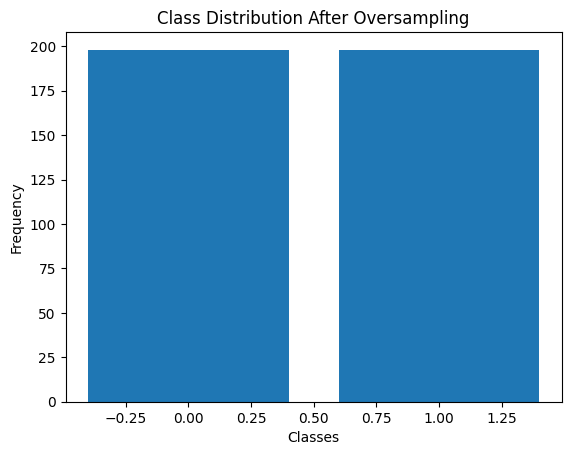

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Medicine           396 non-null    int64   
 1   AgeDiagnosis       396 non-null    float64 
 2   AgeInclusion       396 non-null    float64 
 3   AgeDiagnosisGroup  396 non-null    category
 4   AgeInclusionGroup  396 non-null    category
 5   Duration           396 non-null    float64 
 6   DurationGroup      396 non-null    category
 7   BMI                396 non-null    float64 
 8   BMIGroup           396 non-null    category
 9   Smoking            396 non-null    float64 
 10  Gender             396 non-null    int64   
 11  LocationDiagnosis  396 non-null    float64 
 12  LocationInclusion  396 non-null    float64 
 13  BehaviorDiagnosis  396 non-null    float64 
 14  BehaviorInclusion  396 non-null    float64 
 15  Calpro             396 non-null    float64 
 16  CalproGr

<ipython-input-47-0a3fd6698035>:51: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  icc_resampled_complete_train.replace(999, np.nan, inplace=True)


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC
from collections import Counter

# Define categorical columns
categorical_cols = [
    'AgeDiagnosisGroup', 'AgeInclusionGroup', 'DurationGroup', 'LocationDiagnosis',
    'LocationInclusion', 'BehaviorDiagnosis', 'BehaviorInclusion', 'Smoking', 'BMIGroup', 'CalproGroup', 
    'CRPGroup', 'ThrombocytesGroup', 'Apendectomy', 'CancerEver', 'PriorSurgery', 'PerianalDisease', 'EIM', 
    'PrevMeds'
]

# Extract categorical column indices
categorical_indices = [icc_999_train.columns.get_loc(col) for col in categorical_cols]

# Separate features and target variable
X = icc_999_train.drop('Remission_52w', axis=1)  # Features
y = icc_999_train['Remission_52w']  # Target variable

# Apply SMOTENC to oversample the minority class
smote = SMOTENC(categorical_features=categorical_indices, k_neighbors=3, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert resampled arrays back to DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=['Remission_52w'])

# Concatenate resampled features and target into a new DataFrame
icc_resampled_train = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# Visualize the class distribution after oversampling
counter = Counter(y_resampled)
for label, count in counter.items():
    percentage = (count / len(y_resampled)) * 100
    print(f'Class={label}, n={count} ({percentage:.3f}%)')

# Plot the distribution
plt.bar(counter.keys(), counter.values())
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Class Distribution After Oversampling')
plt.show()

# Drop irrelevant columns
icc_resampled_complete_train = icc_resampled_train.drop(columns=['AgeDiagnosis', 'AgeInclusion', 'Duration', 'BMI', 'CRP', 'Calpro', 
                                                           'Thrombocytes'])
# replace 999 with NULL

icc_resampled_complete_train.replace(999, np.nan, inplace=True)

# Show the cleaned and resampled dataset
print(icc_resampled_train.info())




# **_3. imputation_ICC_**

### Impute with the mode value


In [48]:
from sklearn.impute import SimpleImputer
from numpy import isnan
import numpy as np
import pandas as pd

def impute_missing_values(data):
    """Imputes missing values using the most frequent value in each column."""
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    transformed_values = imputer.fit_transform(data.values)
    return pd.DataFrame(transformed_values, index=data.index, columns=data.columns)

# Apply imputation to test and training datasets
icc_c_test_mode = impute_missing_values(icc_c_test)
icc_c_train_mode = impute_missing_values(icc_c_train)

# Verify missing values have been handled
print("Missing values in test data:", isnan(icc_c_test_mode.values).sum())
print("Missing values in train data:", isnan(icc_c_train_mode.values).sum())


Missing values in test data: 0
Missing values in train data: 0


# **_4. expert_network_**


creates a Bayesian Network object based on expert knowledge, visualizes it, and saves it as a JSON file

In [49]:
import networkx as nx
import matplotlib.pyplot as plt
import json
from pgmpy.base import DAG

# Define the edges for the expert model based on expert knowledge
edges = [
    ('AgeDiagnosisGroup', 'Remission_52w'), ('AgeDiagnosisGroup', 'Apendectomy'), 
    ('AgeDiagnosisGroup', 'CancerEver'), ('AgeDiagnosisGroup', 'PriorSurgery'), 
    ('AgeInclusionGroup', 'Smoking'), ('AgeInclusionGroup', 'Medicine'),
    ('AgeInclusionGroup', 'CancerEver'), ('AgeInclusionGroup', 'BMIGroup'),
    ('AgeInclusionGroup', 'PriorSurgery'),
    ('DurationGroup', 'Remission_52w'), ('DurationGroup', 'PriorSurgery'), 
    ('DurationGroup', 'LocationInclusion'), ('DurationGroup', 'BehaviorInclusion'),
    ('Gender', 'Smoking'), ('Gender', 'Remission_52w'),
    ('LocationDiagnosis', 'PerianalDisease'), ('LocationDiagnosis', 'CancerEver'), 
    ('LocationInclusion', 'PerianalDisease'), ('LocationInclusion', 'CancerEver'),
    ('LocationInclusion', 'CalproGroup'),
    ('BehaviorDiagnosis', 'PriorSurgery'),
    ('BehaviorInclusion', 'CRPGroup'), ('BehaviorInclusion', 'PriorSurgery'), 
    ('Smoking', 'PerianalDisease'), ('Smoking', 'Remission_52w'), ('Smoking', 'BMIGroup'), 
    ('Smoking', 'BehaviorInclusion'), ('Smoking', 'CancerEver'),
    ('CalproGroup', 'Remission_52w'), 
    ('CRPGroup', 'Remission_52w'),
    ('ThrombocytesGroup', 'Remission_52w'), 
    ('PriorSurgery', 'Remission_52w'),
    ('EIM', 'Medicine'), 
    ('PrevMeds', 'Medicine'), ('PrevMeds', 'Remission_52w'),
    ('PerianalDisease', 'Remission_52w'), ('PerianalDisease', 'Medicine'), 
    ('PerianalDisease', 'CRPGroup')
]

# Create the Bayesian Network (DAG) from the expert-defined edges
expert_model = DAG(edges)

# Print the edges of the created DAG for inspection
print("Edges of the Expert Model:")
print(expert_model.edges())

# Convert the expert model to a NetworkX graph for visualization
nx_graph_x = nx.DiGraph(expert_model.edges())

 # Plot the network structures for each method
# Function to format node labels (convert CamelCase or underscore names into readable text)

def format_label(name):
    return re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', name).replace('_', ' ')
    
# Define the plot_graph function with the custom style
def plotGraph(model, title, color, figsize):

    # Convert the model to a NetworkX graph for visualization
    nx_graph = nx.DiGraph(model.edges())

    # Generate formatted labels
    formatted_labels = {node: format_label(node) for node in nx_graph.nodes()}

    # Define colors for each source node (same as provided style)
    colors = {
        'AgeDiagnosisGroup': 'darkorange',
        'AgeInclusionGroup': 'blue',
        'DurationGroup': 'lightgreen',
        'Gender': 'purple',
        'LocationDiagnosis': 'yellow',
        'LocationInclusion': 'brown',
        'BehaviorDiagnosis': 'pink',
        'BehaviorInclusion': 'cyan',
        'Smoking': 'red',
        'CalproGroup': 'black',
        'CRPGroup': 'lime',
        'ThrombocytesGroup': 'lightblue',
        'PriorSurgery': 'darkviolet',
        'EIM': 'teal',
        'PrevMeds': 'gold',
        'PerianalDisease': 'darkgreen'
    }

    # Define edge colors based on the source node
    edge_colors = []
    for u, v in nx_graph.edges():
        if u in colors:
            edge_colors.append(colors[u])  # Color the edge based on the source node

    # Define node color for the target node 'Remission_52w' and other nodes
    node_color = []
    for node in nx_graph.nodes():
        if node == 'Remission_52w':
            node_color.append('coral')  # Highlight target node in lightcoral
        else:
            node_color.append('lightblue')  # Default color for predictor nodes

    # Define node shapes
    node_shapes = {}
    for node in nx_graph.nodes():
        if node == 'Remission_52w':
            node_shapes[node] = 's'  # Square for target node
        else:
            node_shapes[node] = 'o'  # Circle for predictor nodes

    # Set positions for a cleaner layout (using spring layout with higher k to spread nodes more)
    pos = nx.spring_layout(nx_graph, k=2.0, seed=42, iterations=300)

    # Adjust positions slightly to shift labels (move labels to the left and down)
    label_offset_x = 0.06  # Shift labels to the left
    label_offset_y = 0.05  # Shift labels down
    adjusted_pos = {node: (x + label_offset_x, y + label_offset_y) for node, (x, y) in pos.items()}

    # Plot the network with adjusted settings
    plt.figure(figsize=figsize)  # Adjust the figure size for better visualization

    # Draw the nodes with custom shapes
    for node in nx_graph.nodes():
        shape = node_shapes[node]
        nx.draw_networkx_nodes(nx_graph, pos, nodelist=[node], node_size=500,
                               node_color=[node_color[list(nx_graph.nodes()).index(node)]], 
                               node_shape=shape)

    # Draw the edges with custom colors and increased width
    nx.draw_networkx_edges(nx_graph, pos, edge_color=edge_colors, width=3,
                           alpha=1, 
                           arrows=True, arrowsize=20)

    # Draw the labels with bold font and adjust the size
    nx.draw_networkx_labels(nx_graph, adjusted_pos , font_weight='bold',
                             labels=formatted_labels,font_size=13, font_color='black')

    # Add title for better context
    plt.title(title, fontsize=16)
    plt.axis('off')  # Turn off axis for a cleaner view
    plt.show()


Edges of the Expert Model:
[('AgeDiagnosisGroup', 'Remission_52w'), ('AgeDiagnosisGroup', 'Apendectomy'), ('AgeDiagnosisGroup', 'CancerEver'), ('AgeDiagnosisGroup', 'PriorSurgery'), ('PriorSurgery', 'Remission_52w'), ('AgeInclusionGroup', 'Smoking'), ('AgeInclusionGroup', 'Medicine'), ('AgeInclusionGroup', 'CancerEver'), ('AgeInclusionGroup', 'BMIGroup'), ('AgeInclusionGroup', 'PriorSurgery'), ('Smoking', 'PerianalDisease'), ('Smoking', 'Remission_52w'), ('Smoking', 'BMIGroup'), ('Smoking', 'BehaviorInclusion'), ('Smoking', 'CancerEver'), ('DurationGroup', 'Remission_52w'), ('DurationGroup', 'PriorSurgery'), ('DurationGroup', 'LocationInclusion'), ('DurationGroup', 'BehaviorInclusion'), ('LocationInclusion', 'PerianalDisease'), ('LocationInclusion', 'CancerEver'), ('LocationInclusion', 'CalproGroup'), ('BehaviorInclusion', 'CRPGroup'), ('BehaviorInclusion', 'PriorSurgery'), ('Gender', 'Smoking'), ('Gender', 'Remission_52w'), ('LocationDiagnosis', 'PerianalDisease'), ('LocationDiagnosis

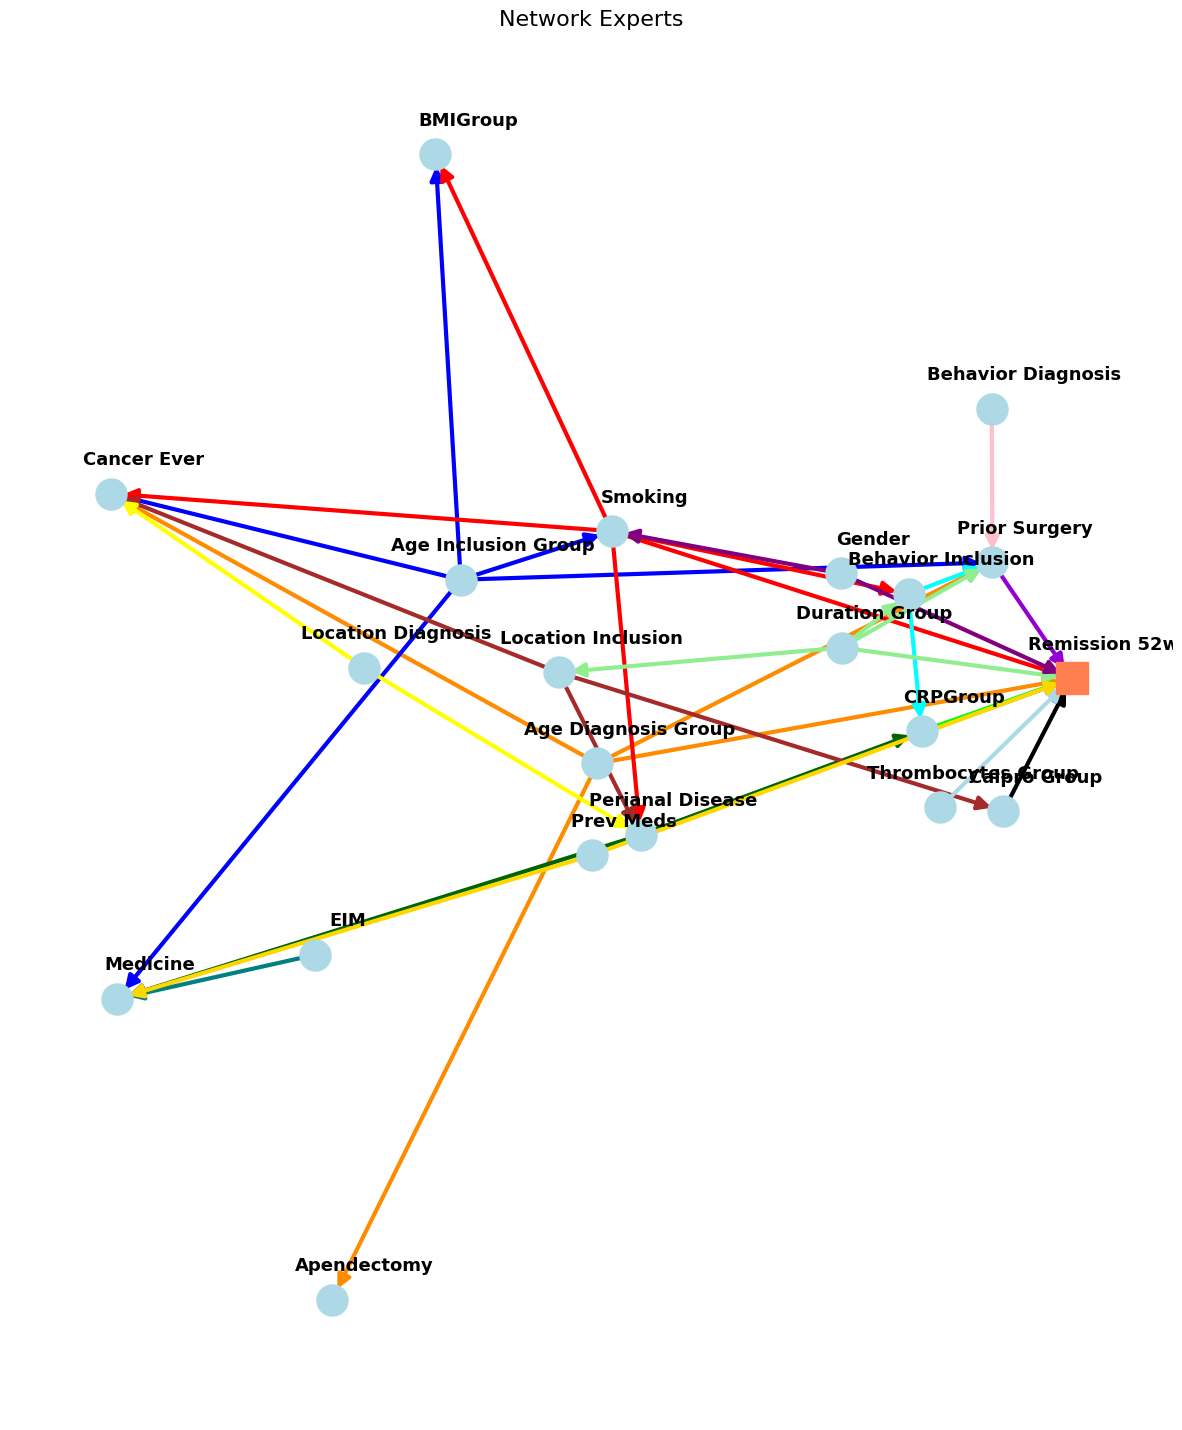

In [50]:
plotGraph(nx_graph_x, "Network Experts", 'red', (15, 18))

In [51]:
# Save the visualization as a JSON file for further use or sharing
#file_path = "C:/Users/maikk/Documents/uni/thesis/master-thesis-CD/BayesianNetworkICC/DAGs/"
file_x = 'expert_model.json' #file_path + 'expert_model.json'

# Export the graph as a JSON file
json_x = json.dumps(nx.cytoscape_data(nx_graph_x), indent=2)
with open(file_x, 'w') as file:
    file.write(json_x)

print(f"The expert model has been saved as a JSON file at: {file_x}")


The expert model has been saved as a JSON file at: expert_model.json


# **_5. structure_learning_expert_HC_ICC_**

The following process aims to apply the Hill Climb Search (HCS) method to structure learning, exploring the best network structure for the given data using different scoring methods. It involves several stages: initializing the search algorithm, defining scoring methods, applying blacklists and whitelists for edges, and searching for the best structure using different scoring methods. After that, the best structures are visualized as directed graphs, and the results are saved in JSON format for use in Cytoscape for further manipulation and visualization

In [52]:
# Import required libraries
import json
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDeuScore, BDsScore

# Define the state names for categorical variables to guide the learning process
state_names = {
    'DurationGroup': [1, 2, 3],
    'EIM': [0, 1, 2, 3, 4, 5, 6, 7],
    'PrevMeds': [0, 1, 2 ,3]
}

# Initialize Hill Climb Search with the training data
hill_climb = HillClimbSearch(data=icc_resampled_complete_train)

# Define scoring methods for the structure learning process
scoring_methods = {
    'bic': BicScore(data=icc_resampled_complete_train),
    'k2': K2Score(data=icc_resampled_complete_train),
    'bdeu': BDeuScore(data=icc_resampled_complete_train),
    'bds': BDsScore(data=icc_resampled_complete_train)
}

# Extract columns excluding the target variable
cols = icc_c_train.columns.drop('Remission_52w')

# Initialize blacklists for restricted edges
black_list = []

# Blacklist all edges originating from 'Remission_52w'
for col in icc_c_train.columns:
    edge = ('Remission_52w', col)
    black_list.append(edge)
black_list.remove(('Remission_52w', 'Remission_52w'))  # Remove self-loop

# Blacklist edges from any column to basic columns
basic_cols = ['Gender', 'AgeDiagnosisGroup', 'AgeInclusionGroup', 'DurationGroup']
for col in icc_c_train.columns:
    for b_col in basic_cols:
        if col != b_col:
            edge = (col, b_col)
            black_list.append(edge)

# Blacklist edges that source from events occurring after the target
prior_cols = ['CancerEver', 'PriorSurgery', 'Smoking', 'PrevMeds', 'Appendectomy', 'LocationDiagnosis', 'BehaviorDiagnosis']
incl_cols = ['EIM', 'BMIGroup', 'CRPGroup', 'CalproGroup', 'ThrombocytesGroup', 'Medicine', 'LocationInclusion', 
             'BehaviorInclusion', 'PerianalDisease']

for p_col in prior_cols:
    for i_col in incl_cols:
        edge = (i_col, p_col)
        black_list.append(edge)

# Define the whitelist as the edges from the expert model
white_list = expert_model.edges()

# Prepare multiple copies of the expert model for different scoring methods
start_dags = {
    'k2': expert_model.copy(),
    'bic': expert_model.copy(),
    'bdeu': expert_model.copy(),
    'bds': expert_model.copy()
}

# Perform structure learning using Hill Climb Search with different scoring methods
best_models = {}
for method, dag in start_dags.items():
    best_models[method] = hill_climb.estimate(scoring_method=scoring_methods[method], 
                                               start_dag=dag, 
                                               black_list=black_list, 
                                               white_list=white_list)


# Saving the graphs as JSON for Cytoscape visualization
def save_graph_json(graph, file_name):
    """Saves the graph data in Cytoscape-compatible JSON format."""
    #file_path = "C:/Users/maikk/Documents/uni/thesis/master-thesis-CD/BayesianNetworkICC/DAGs/"
    json_data = json.dumps(nx.cytoscape_data(graph), indent=2)
    with open( file_name, 'w') as file: # file_path +
        file.write(json_data)

# Saving the models as JSON files
save_graph_json(nx.DiGraph(best_models['k2'].edges()), 'k2_x.json')
save_graph_json(nx.DiGraph(best_models['bic'].edges()), 'bic_x.json')
save_graph_json(nx.DiGraph(best_models['bdeu'].edges()), 'bdeu_x.json')
save_graph_json(nx.DiGraph(best_models['bds'].edges()), 'bds_x.json')

print("The models have been saved as JSON files for Cytoscape visualization.")


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

The models have been saved as JSON files for Cytoscape visualization.


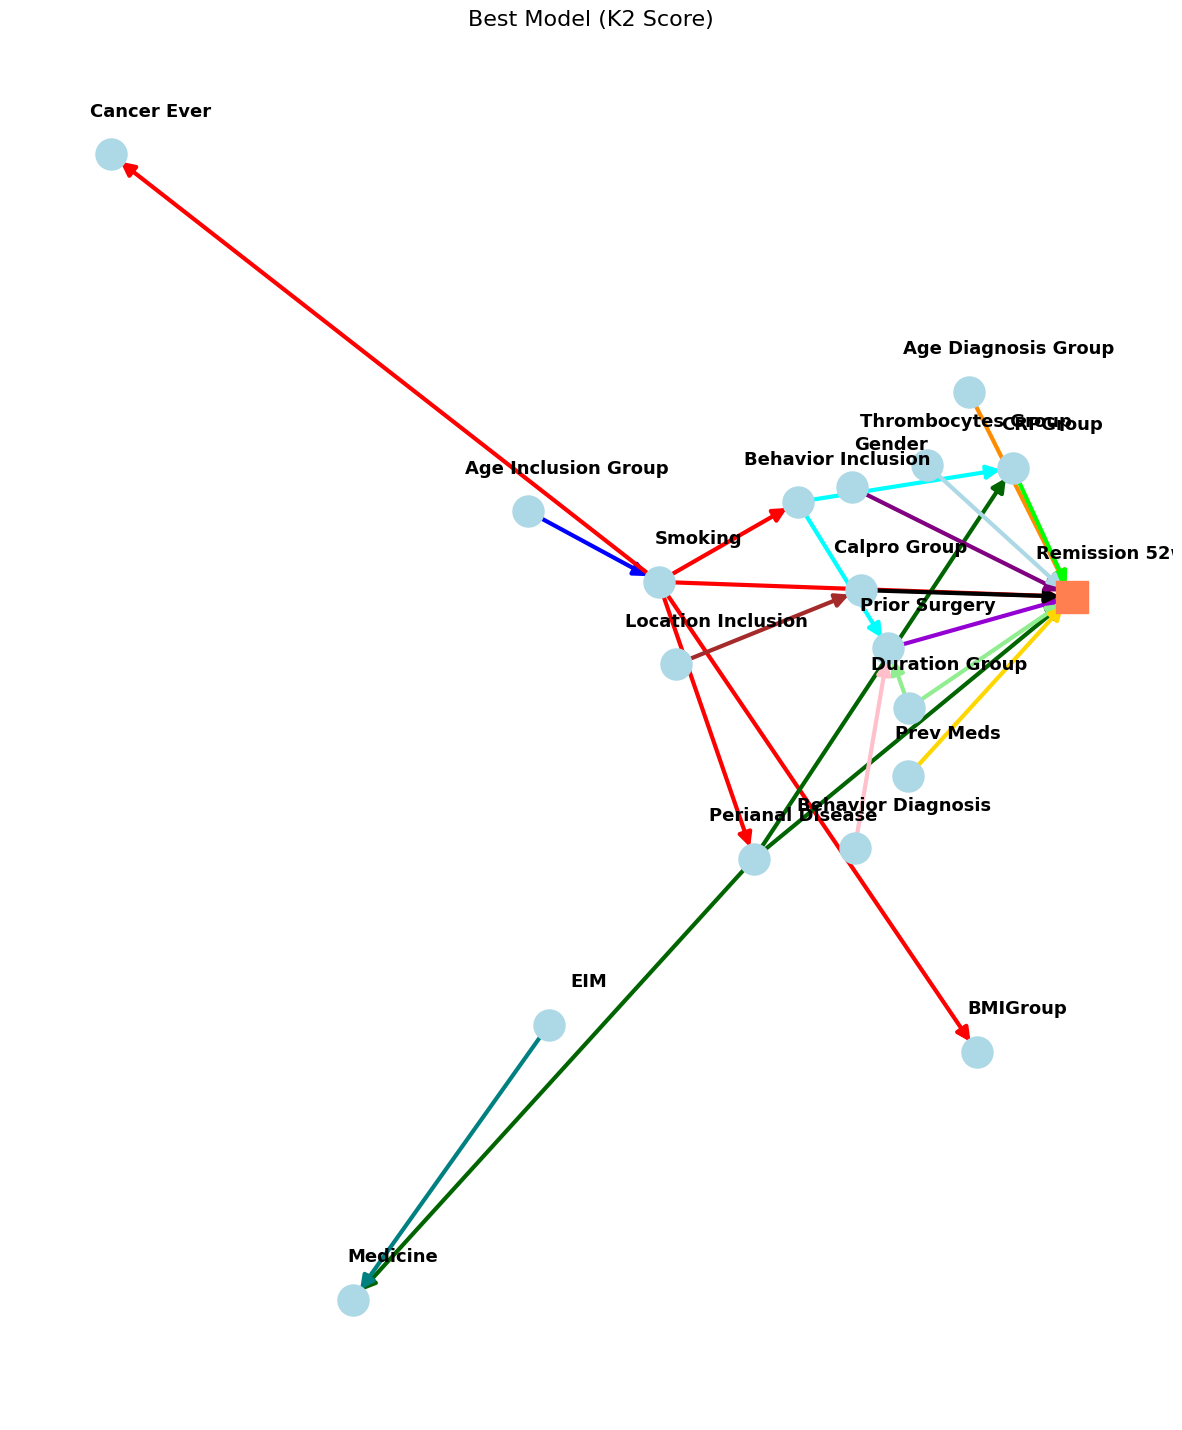

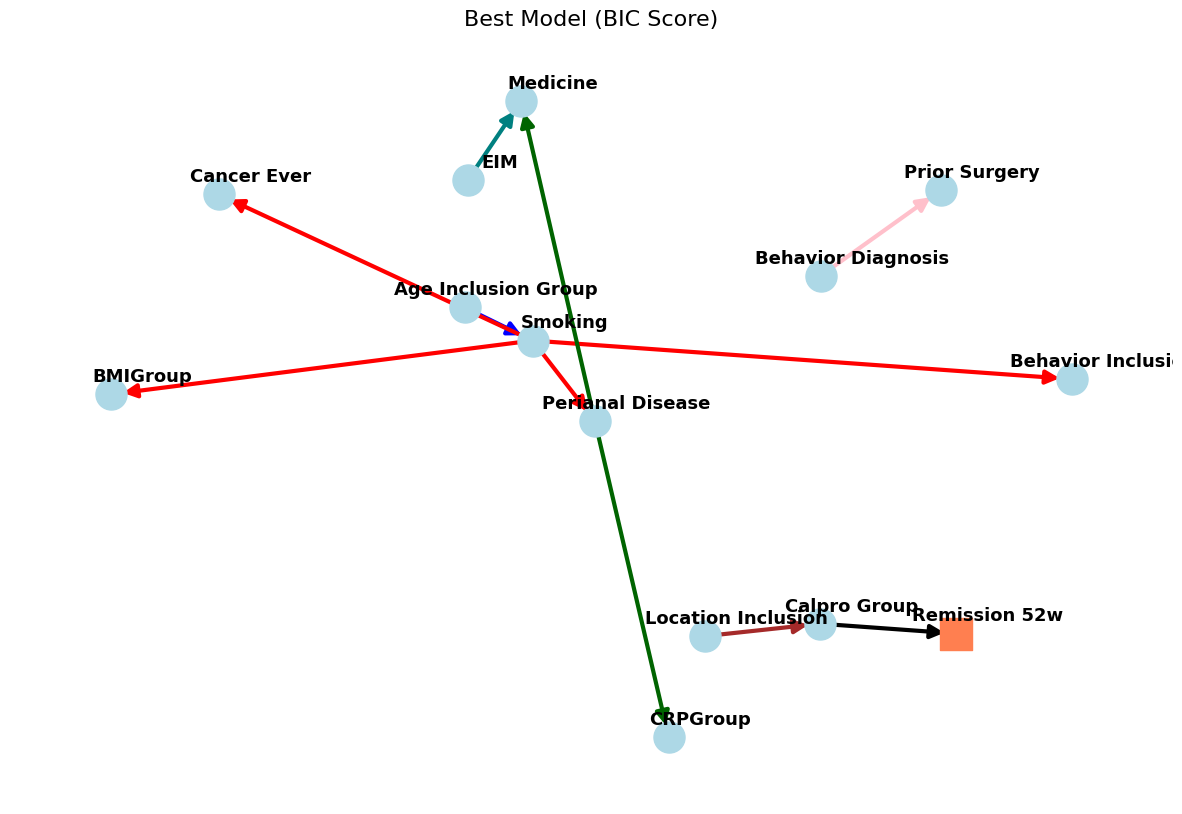

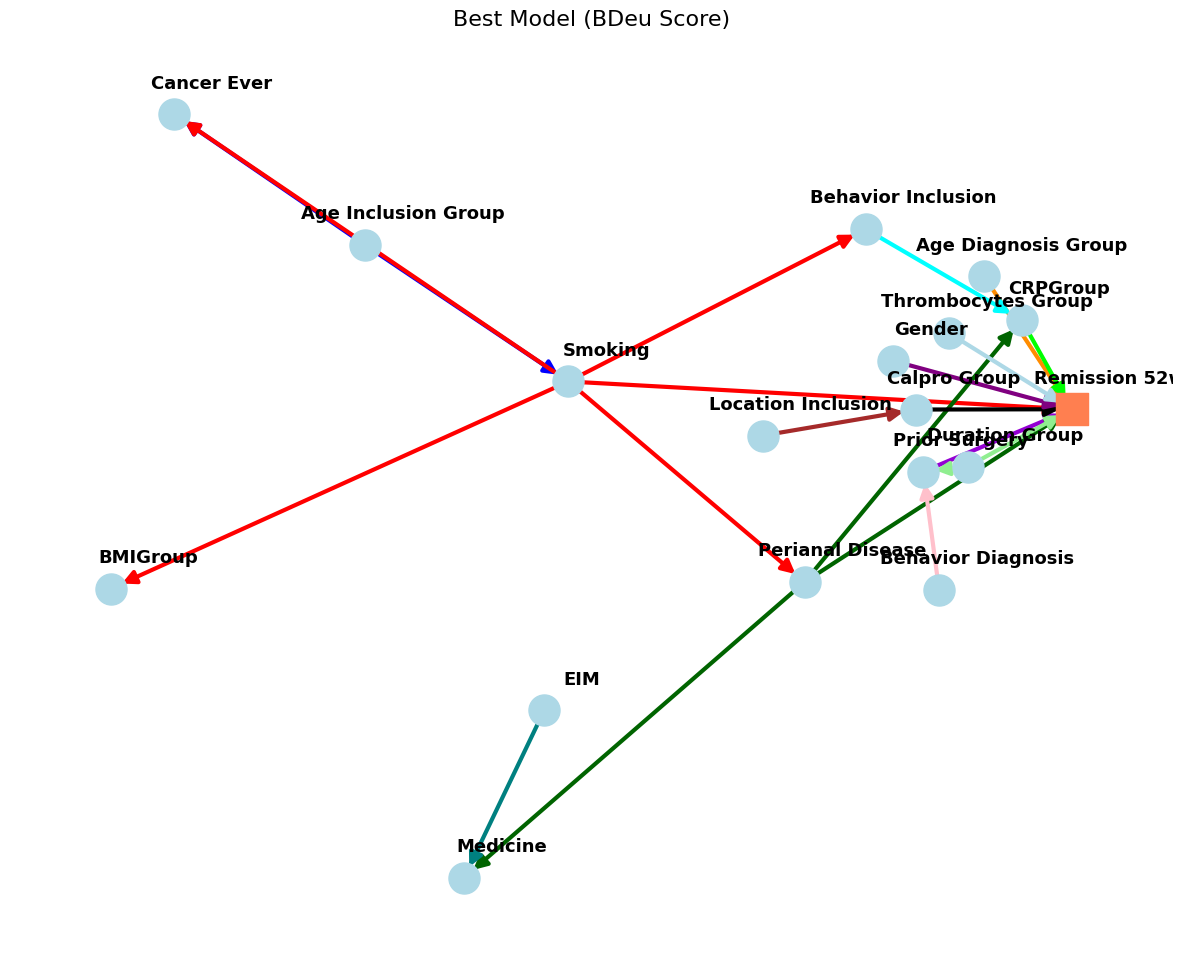

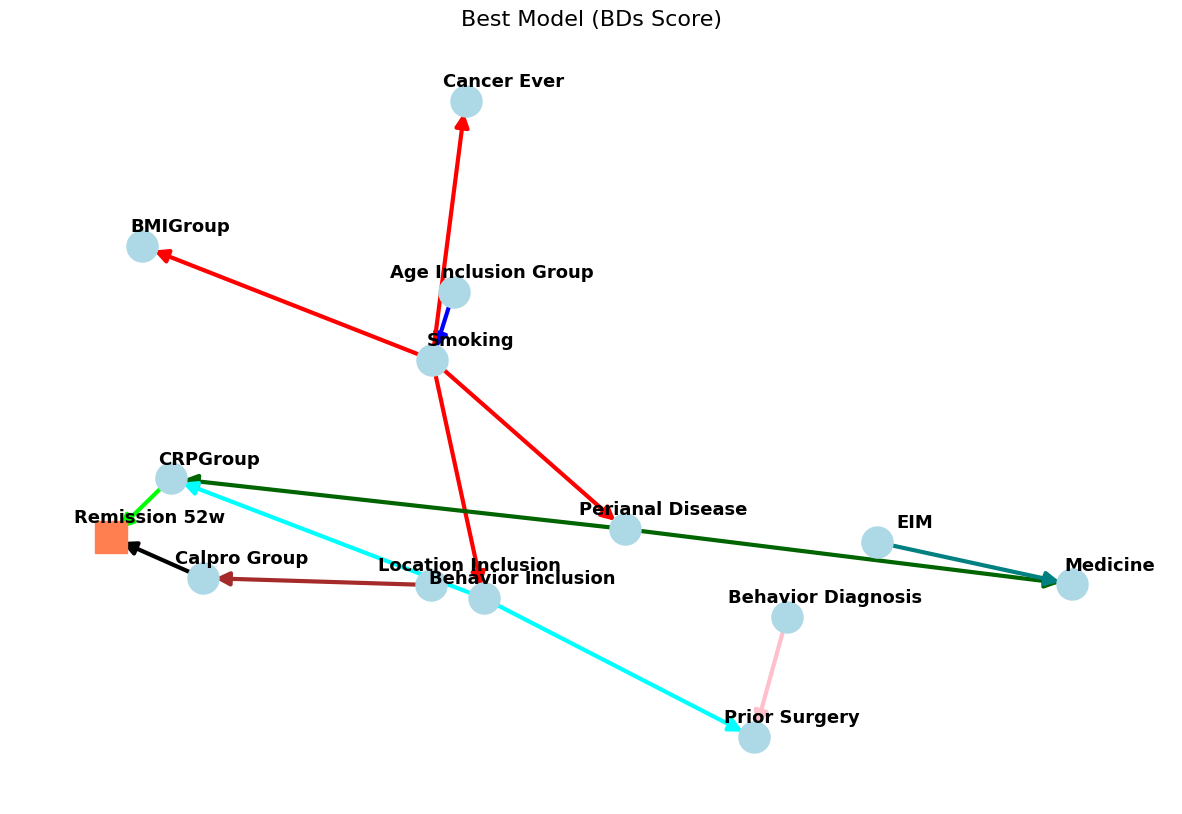

In [53]:

# Visualizing the best models for each scoring method with the same style
plotGraph(best_models['k2'], "Best Model (K2 Score)", 'pink', (15, 18))
plotGraph(best_models['bic'], "Best Model (BIC Score)", 'green',(15, 10))
plotGraph(best_models['bdeu'], "Best Model (BDeu Score)", 'blue', (15, 12))
plotGraph(best_models['bds'], "Best Model (BDs Score)", 'grey', (15, 10))


# **_6. bayesian_network_ICC_**

In [54]:
#%run structure_learning_expert_HC_ICC.ipynb
#%run mice_imputation_ICC.ipynb

### **Step 1: Define and Train Bayesian Networks**

We begin by constructing two Bayesian Networks: one using a data-driven structure (`best_model_k2`) and another based on expert knowledge (`expert_model`). Both networks are trained using Bayesian Estimation with a Dirichlet prior (`BDeu`) and an equivalent sample size of 1.

In [55]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator

# Data-driven Bayesian Network
bn = BayesianNetwork(best_models['k2'].edges())
bn.fit(
    data=icc_resampled_complete_train,
    estimator=BayesianEstimator,
    prior_type="BDeu",
    equivalent_sample_size=1
)

# Expert-defined Bayesian Network
bn_expert = BayesianNetwork(expert_model.edges())
bn_expert.fit(
    data=icc_resampled_complete_train,
    estimator=BayesianEstimator,
    prior_type="BDeu",
    equivalent_sample_size=1
)

# Display Conditional Probability Distribution for a target variable
print(bn.get_cpds('Remission_52w'))

+--------------------+----------------------+-----+----------------------+
| AgeDiagnosisGroup  | AgeDiagnosisGroup(1) | ... | AgeDiagnosisGroup(4) |
+--------------------+----------------------+-----+----------------------+
| CRPGroup           | CRPGroup(1)          | ... | CRPGroup(2)          |
+--------------------+----------------------+-----+----------------------+
| CalproGroup        | CalproGroup(1)       | ... | CalproGroup(3)       |
+--------------------+----------------------+-----+----------------------+
| DurationGroup      | DurationGroup(1)     | ... | DurationGroup(3)     |
+--------------------+----------------------+-----+----------------------+
| Gender             | Gender(1)            | ... | Gender(2)            |
+--------------------+----------------------+-----+----------------------+
| PerianalDisease    | PerianalDisease(0.0) | ... | PerianalDisease(1.0) |
+--------------------+----------------------+-----+----------------------+
| PrevMeds           | Pr

### **Step 2: Identifying Missing Columns in the Bayesian Network**

Some columns present in the dataset may have been excluded during structure learning. We identify these missing columns and store them for later preprocessing.

In [56]:
abs_cols = [col for col in icc_c_test.columns if col not in bn]
for col in abs_cols:
    print(col)

LocationDiagnosis
Apendectomy


### **Step 3: Preprocessing Test and Training Data**

To ensure compatibility with the Bayesian Network, we remove the excluded columns and use imputed versions of the datasets since Bayesian Network algorithms do not handle missing values.

In [57]:
test_data_mode = icc_c_test_mode.drop(columns=abs_cols)
train_data_mode = icc_c_train_mode.drop(columns=abs_cols)
icc_c_test_drop = icc_c_test.drop(columns=abs_cols)


### **Step 4: Evaluating Bayesian Network Performance**

We assess how well the Bayesian Network structure represents correlations in the data using correlation scores and structure scores.

In [58]:
from pgmpy.metrics import correlation_score, structure_score

# Correlation Score
correlation_score(bn, test_data_mode, test='chi_square', significance_level=0.05)

# Structure Score (Higher score indicates a better fit)
structure_score(bn, test_data_mode, scoring_method='k2')


-1823.8569844873666

### **Step 5: Making Predictions and Computing ROC-AUC Score**

We use the trained Bayesian Network to predict probabilities and evaluate the model using the ROC-AUC metric.


In [59]:
from sklearn.metrics import roc_auc_score

test_data_mode_no_outcome = test_data_mode.drop(columns=['Remission_52w'])

# Predict probabilities
predicted_probs = bn.predict_probability(test_data_mode_no_outcome)

# Compute AUC-ROC Score
outcome = icc_c_test.Remission_52w
auc_roc = roc_auc_score(outcome, predicted_probs['Remission_52w_1.0'])
print("HC Network AUC-ROC Score:", auc_roc)

HC Network AUC-ROC Score: 0.4256470588235295


### **Step 6: Plotting the ROC Curve**

The ROC curve helps visualize the trade-off between sensitivity and specificity.

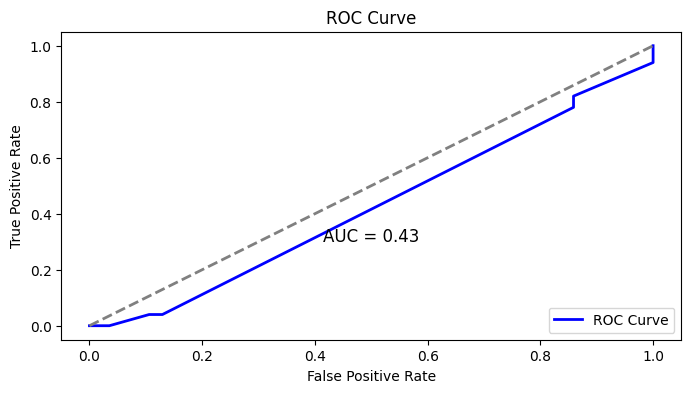

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(outcome, predicted_probs['Remission_52w_1.0'])

plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.text(0.5, 0.3, f'AUC = {auc_roc:.2f}', fontsize=12, ha='center')
plt.show()

### **Step 7: Performance Metrics – Accuracy and Recall**

We evaluate the model further using accuracy and recall scores.


In [61]:
from sklearn.metrics import accuracy_score, recall_score

predicted_states = bn.predict(test_data_mode_no_outcome)

acc_score = accuracy_score(outcome, predicted_states)
recall = recall_score(outcome, predicted_states)

print(f"Accuracy Score: {acc_score}")
print(f"Recall Score: {recall}")

  0%|          | 0/134 [00:00<?, ?it/s]

Accuracy Score: 0.562962962962963
Recall Score: 0.04


### **Step 8: Confusion Matrix and Classification Report**

The confusion matrix provides a detailed breakdown of prediction performance.


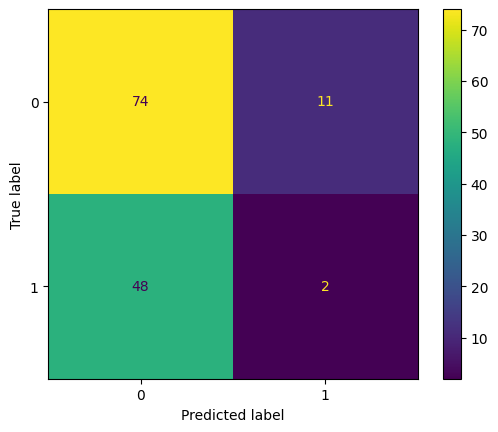


Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.87      0.71        85
         1.0       0.15      0.04      0.06        50

    accuracy                           0.56       135
   macro avg       0.38      0.46      0.39       135
weighted avg       0.44      0.56      0.47       135



In [62]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(outcome, predicted_states)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(outcome, predicted_states))

### **Step 9: Model Calibration Curve**

A calibration curve helps check how well-predicted probabilities align with observed outcomes.

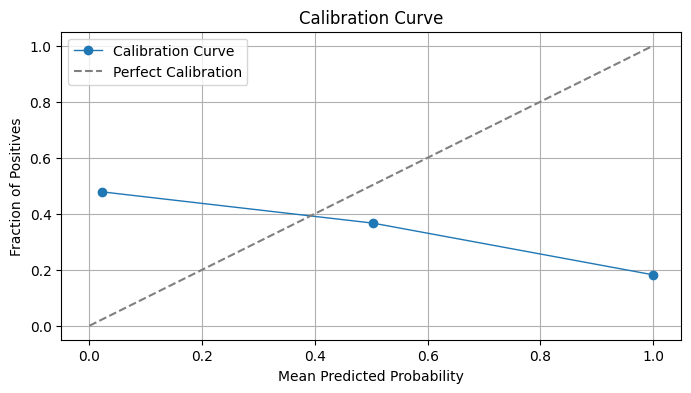

In [63]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(outcome, predicted_probs['Remission_52w_1.0'], n_bins=3)

plt.figure(figsize=(8,4))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


### **Step 10: Node Removal to Improve AUC-ROC Score**

We systematically remove nodes to evaluate their impact on AUC-ROC.

In [64]:
from pgmpy.estimators import MaximumLikelihoodEstimator

def compute_auc_after_node_removal(bn, train_data, test_data):
    best_auc, best_removed_node = 0, None

    for node in bn.nodes:
        if node != 'Remission_52w':
            temp_model = bn.copy()
            temp_model.remove_node(node)

            bayesian_network = BayesianNetwork(temp_model.edges)
            bayesian_network.fit(
                data=train_data,
                estimator=BayesianEstimator,
                prior_type="BDeu",
                equivalent_sample_size=1
            )

            if 'Remission_52w' in bayesian_network:
                prediction_data = test_data[[n for n in bayesian_network.nodes if n != 'Remission_52w']]
                predicted_probs = bayesian_network.predict_probability(prediction_data)
                auc_roc = roc_auc_score(test_data['Remission_52w'], predicted_probs['Remission_52w_1.0'])

                print(f"Removed {node}, AUC-ROC: {auc_roc}")

                if auc_roc > best_auc:
                    best_auc, best_removed_node = auc_roc, node

    return best_auc, best_removed_node

best_auc, best_removed_node = compute_auc_after_node_removal(bn, icc_resampled_complete_train, icc_c_test_mode)
print("Best AUC:", best_auc)
print("Node Removed for Best AUC:", best_removed_node)


Removed AgeDiagnosisGroup, AUC-ROC: 0.4135294117647058
Removed PriorSurgery, AUC-ROC: 0.4194117647058824
Removed AgeInclusionGroup, AUC-ROC: 0.4256470588235295
Removed Smoking, AUC-ROC: 0.5690588235294117
Removed PerianalDisease, AUC-ROC: 0.37588235294117645
Removed BMIGroup, AUC-ROC: 0.4256470588235295
Removed BehaviorInclusion, AUC-ROC: 0.4256470588235295
Removed CancerEver, AUC-ROC: 0.4256470588235295
Removed DurationGroup, AUC-ROC: 0.41117647058823525
Removed LocationInclusion, AUC-ROC: 0.4256470588235295
Removed CalproGroup, AUC-ROC: 0.5098823529411766
Removed CRPGroup, AUC-ROC: 0.4629411764705883
Removed Gender, AUC-ROC: 0.44070588235294117
Removed Medicine, AUC-ROC: 0.4256470588235295
Removed BehaviorDiagnosis, AUC-ROC: 0.4256470588235295
Removed ThrombocytesGroup, AUC-ROC: 0.45258823529411757
Removed EIM, AUC-ROC: 0.4256470588235295
Removed PrevMeds, AUC-ROC: 0.4256470588235295
Best AUC: 0.5690588235294117
Node Removed for Best AUC: Smoking


### **Step 11: Visualizing the Bayesian Network After Node Removal**

We draw the Bayesian Network after removing the best nodes

In [65]:
import networkx as nx
import matplotlib.pyplot as plt

# Check if the original graph is empty
if len(bn.nodes) == 0:
    raise ValueError("Error: The original graph 'bn' is empty!")

# Make a copy of the graph to preserve the original structure
bn_remove_best_node = bn.copy()

# Check if the node exists before removing it
if best_removed_node in bn_remove_best_node.nodes:
    print(f"Removing node: {best_removed_node}")
    bn_remove_best_node.remove_node(best_removed_node)
else:
    print(f"Warning: Node '{best_removed_node}' not found in the graph.")

# Check if the graph is empty after node removal
if len(bn_remove_best_node.nodes) == 0:
    raise ValueError("Error: The graph is empty after removing the node!")

# Convert to a directed graph
nx_graph_best = nx.DiGraph(bn_remove_best_node)

# Debugging: Print remaining nodes and edges
print("Remaining Nodes:", nx_graph_best.nodes)
print("Remaining Edges:", nx_graph_best.edges)

# Ensure there are edges before plotting


Removing node: Smoking
Remaining Nodes: ['AgeDiagnosisGroup', 'Remission_52w', 'PriorSurgery', 'AgeInclusionGroup', 'PerianalDisease', 'BMIGroup', 'BehaviorInclusion', 'CancerEver', 'DurationGroup', 'LocationInclusion', 'CalproGroup', 'CRPGroup', 'Gender', 'Medicine', 'BehaviorDiagnosis', 'ThrombocytesGroup', 'EIM', 'PrevMeds']
Remaining Edges: [('AgeDiagnosisGroup', 'Remission_52w'), ('PriorSurgery', 'Remission_52w'), ('PerianalDisease', 'Remission_52w'), ('PerianalDisease', 'Medicine'), ('PerianalDisease', 'CRPGroup'), ('BehaviorInclusion', 'CRPGroup'), ('BehaviorInclusion', 'PriorSurgery'), ('DurationGroup', 'Remission_52w'), ('DurationGroup', 'PriorSurgery'), ('LocationInclusion', 'CalproGroup'), ('CalproGroup', 'Remission_52w'), ('CRPGroup', 'Remission_52w'), ('Gender', 'Remission_52w'), ('BehaviorDiagnosis', 'PriorSurgery'), ('ThrombocytesGroup', 'Remission_52w'), ('EIM', 'Medicine'), ('PrevMeds', 'Remission_52w')]


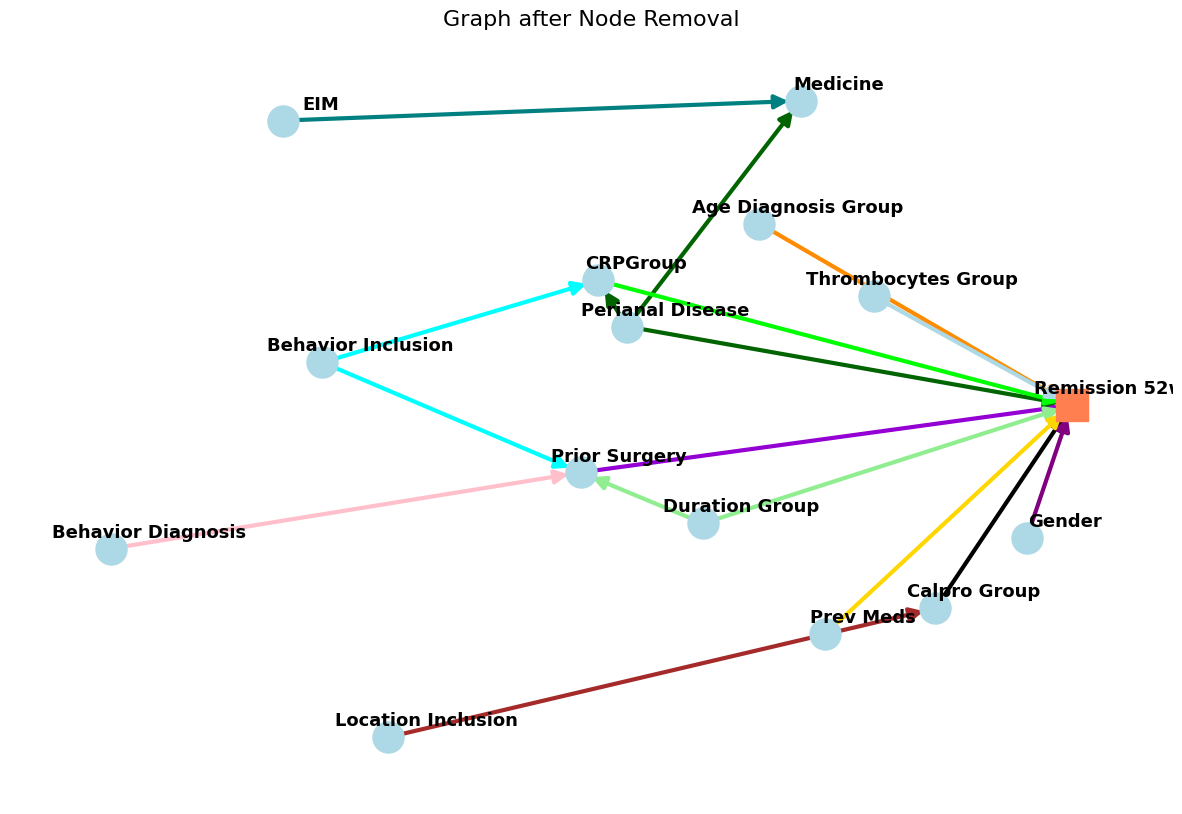

In [66]:
plotGraph(nx_graph_best, "Graph after Node Removal", 'pink', (15, 10))
